In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mping
%matplotlib qt

import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip, ImageClip
from IPython.display import HTML
%matplotlib inline

In [2]:
objpoint=np.zeros((9*6,3),np.float32)
objpoint[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
#print("ObjShape",objpoint)

objpoints=[] #3d points in real world
imagepoints=[] #2d ponits in image plane
objpoints1=[] #3d points in real world
imagepoints1=[] #2d ponits in image plane

images=glob.glob('camera_cal/calibration*.jpg')

for fimages in images:
    img=mping.imread(fimages)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
    
    if(ret==1):
        
        objpoints.append(objpoint)
        imagepoints.append(corners)
        cv2.drawChessboardCorners(img,(9,6),corners,ret)
        
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()
        


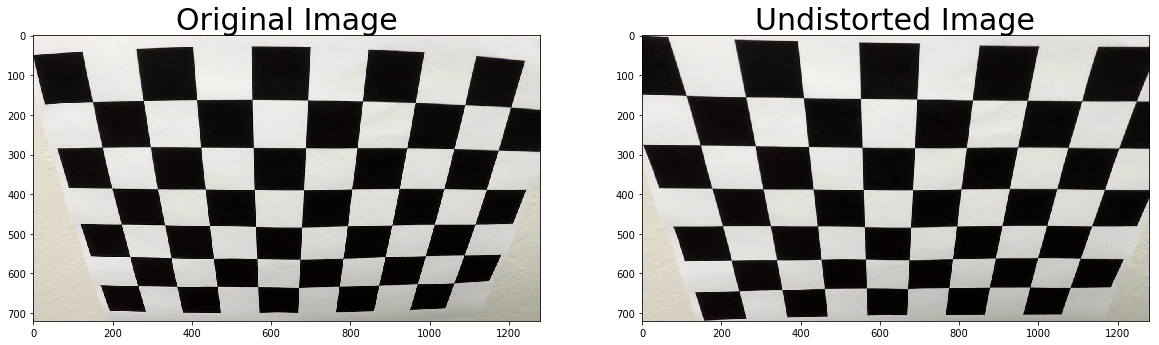

In [3]:
%matplotlib inline
image=mping.imread('camera_cal/calibration2.jpg')
img_size=(image.shape[0],image.shape[1])

ret,mtx,dist,rvec,trvec=cv2.calibrateCamera(objpoints,imagepoints,img_size,None,None)

undistort=cv2.undistort(image,mtx,dist,None,mtx)

cv2.imwrite('output_images/test_undist.jpg',undistort)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=30)


In [4]:
def color_gradient(img,sobel_kernel=31, s_thresh=(100, 255), sx_thresh=(80, 220)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    r_channel=img[:,:,0]
   
        
    # Sobel x and y
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel) # Take the derivative in y
    abs_sobelx=np.absolute(sobelx)
    scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    mag_thresh=(30, 100)
    abs_sobel = np.sqrt(sobelx**2+sobely**2) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh=(0.7, 1.5)
    magnitude=np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])&(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])&(magnitude <= thresh[1])&(magnitude >= thresh[0])]=1
    
    # Sobel x_R
    sobel_R = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    abs_sobel_R=np.absolute(sobel_R)
    scaled_sobel_R = np.uint8(255*abs_sobel_R/np.max(abs_sobel_R))
    
    # Threshold x_R gradient
    sxbinary_R = np.zeros_like(scaled_sobel_R)
    sxbinary_R[(scaled_sobel_R >= sx_thresh[0]) & (scaled_sobel_R <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(l_channel)
    s_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1
    
    # Threshold color channel
    s_binary_R = np.zeros_like(r_channel)
    s_binary_R[(r_channel >= s_thresh[0]) & (r_channel <= s_thresh[1])] = 1
    
    
    color_binary = np.dstack(( np.zeros_like(sxbinary),sxbinary,s_binary_R)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary_R == 1)) | ((sxbinary == 1))] = 1
    return combined_binary,color_binary

In [5]:
def corners_unwarp_lane_lines(img, nx, ny, mtx, dist):
    
        undistorted=cv2.undistort(img,mtx,dist,None,mtx)
        
        #gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
        
        img_size=(undistort.shape[1], undistort.shape[0])
        
        #print(img_size)
        
        src=np.float32([(590, 460),(716, 460),(190, 720),(1240, 720)])
        
        dst=np.float32([(100, 0),(960, 0), (100, 720), 
                                     (960, 720)
                                     ])
        
        M_unwrap=cv2.getPerspectiveTransform(src,dst)

        Mvin=cv2.getPerspectiveTransform(dst,src)

        wrapped=cv2.warpPerspective(img,M_unwrap,img_size)
        


        return wrapped, M_unwrap,Mvin,undistorted

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


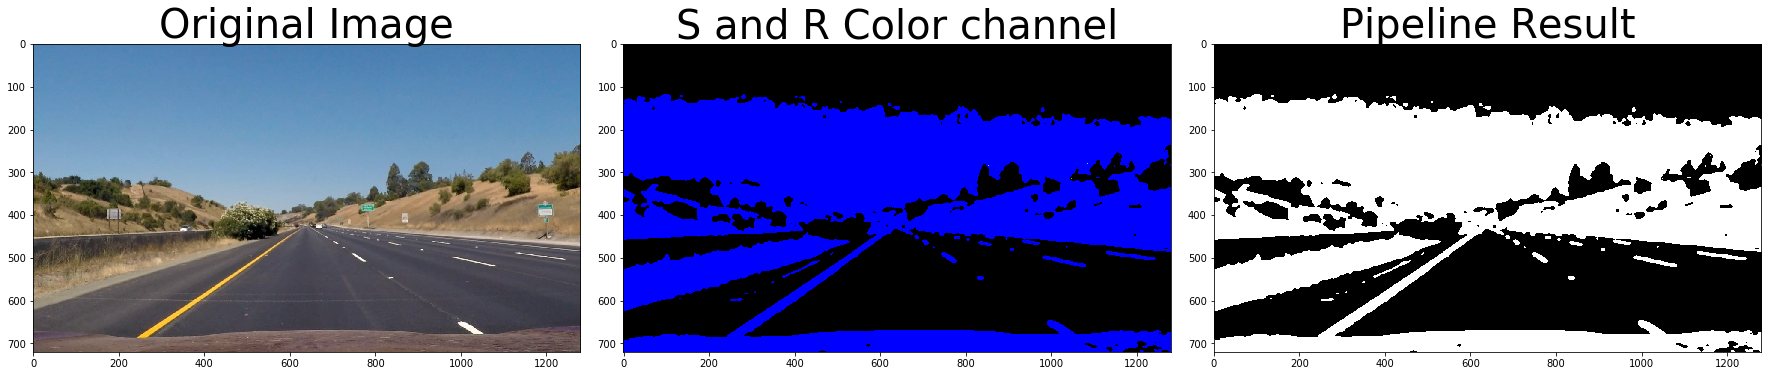

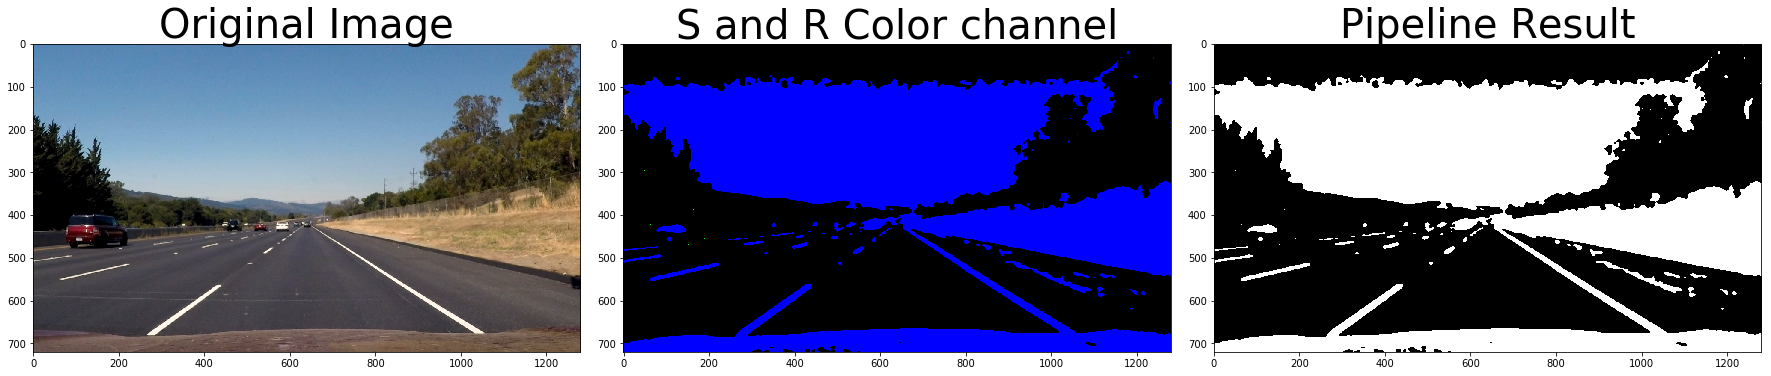

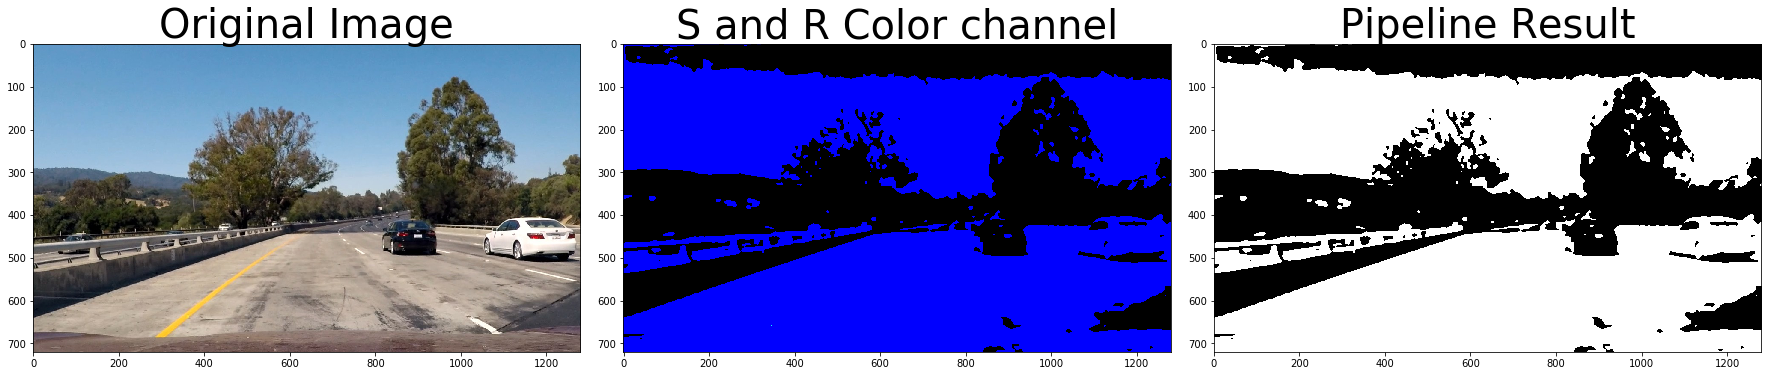

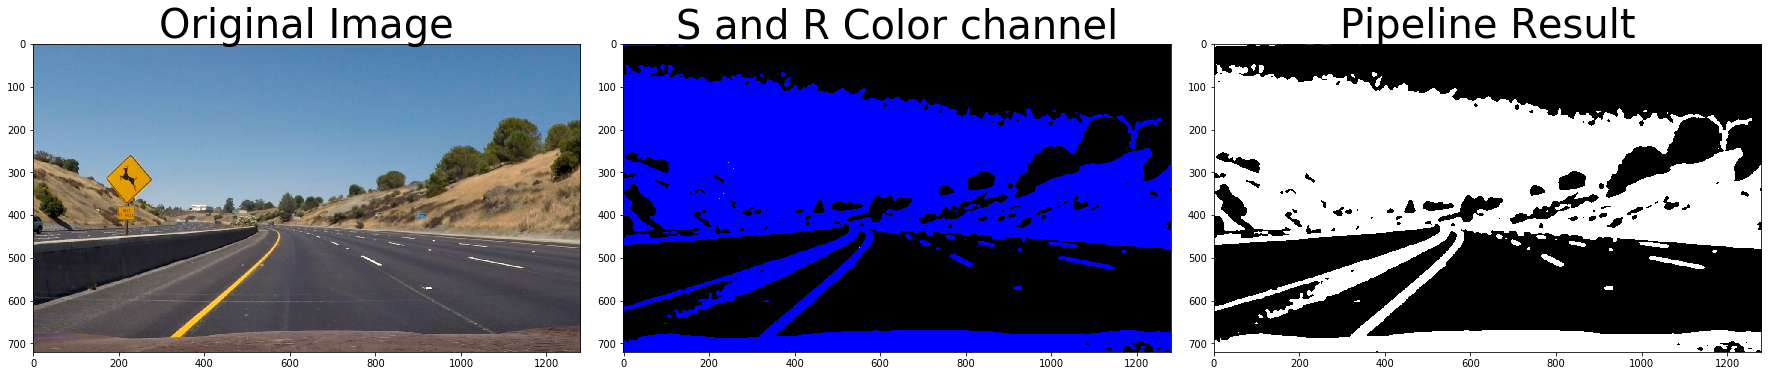

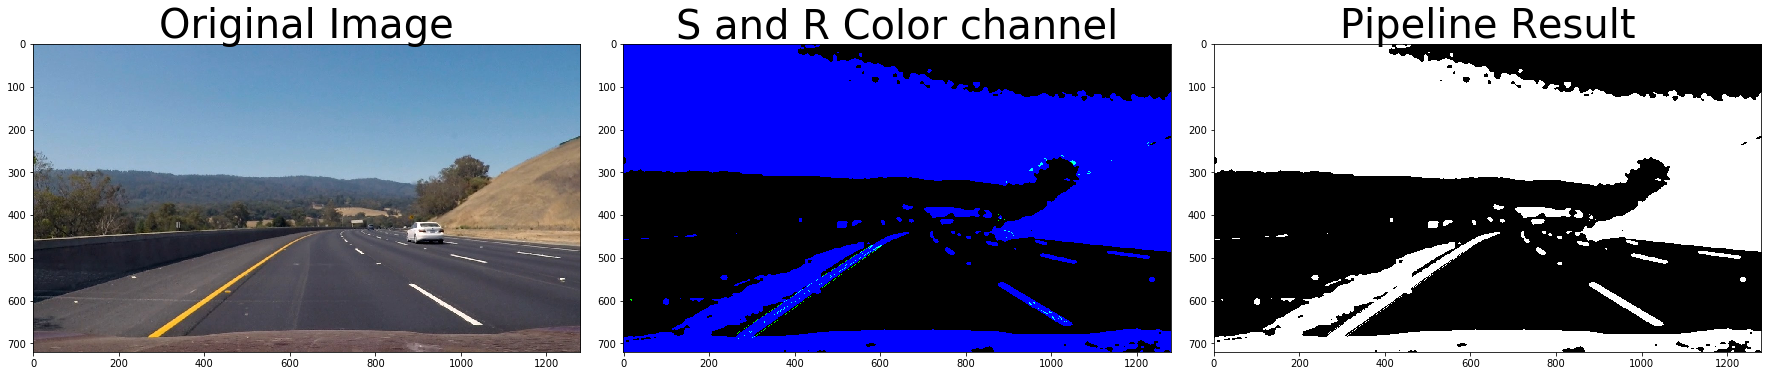

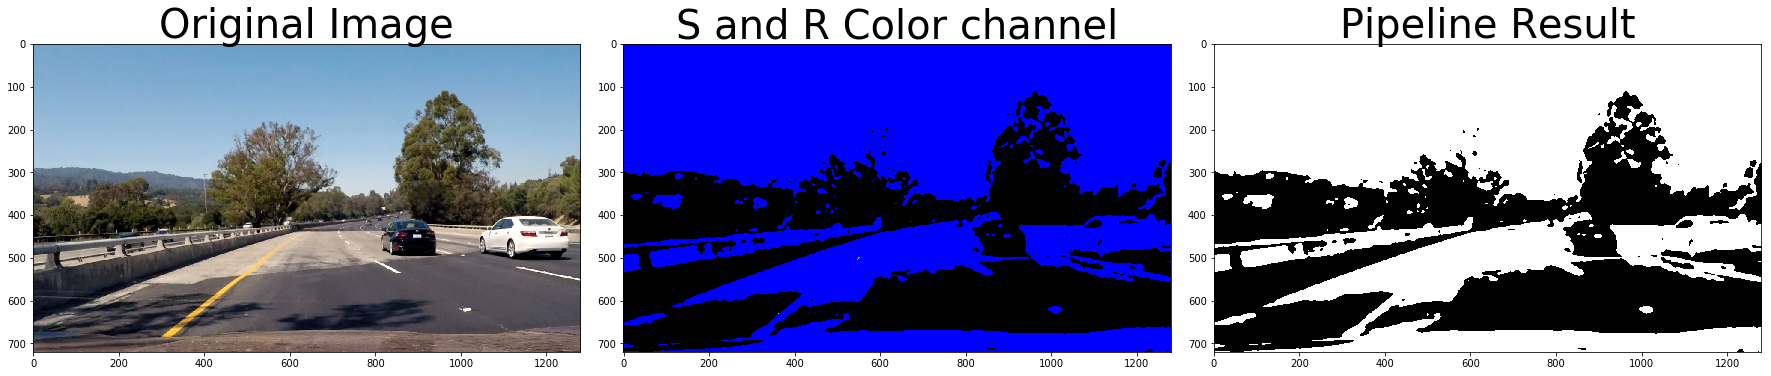

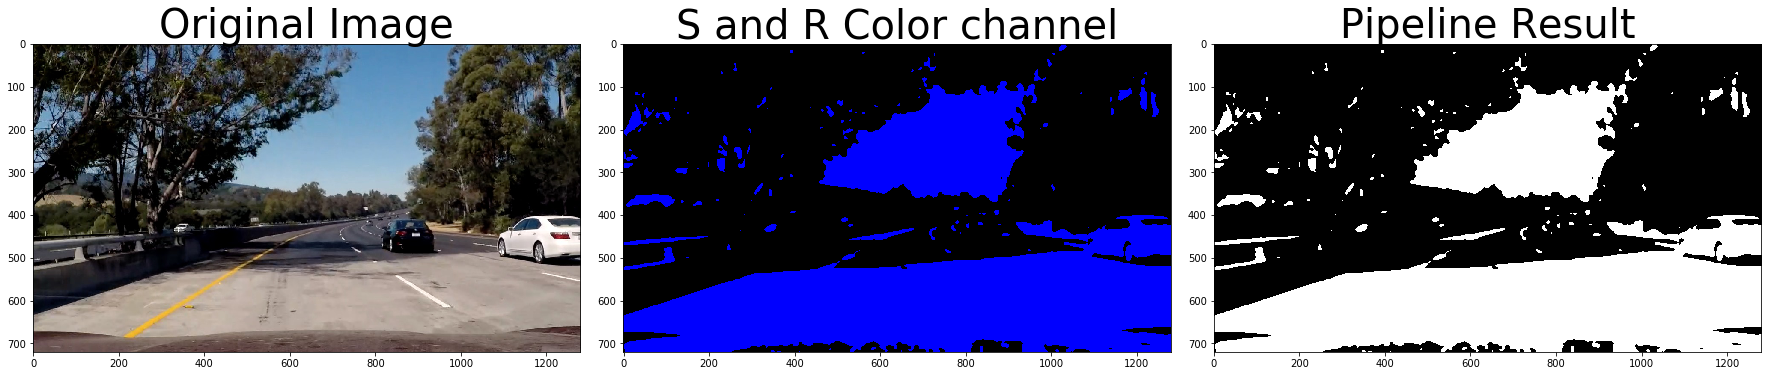

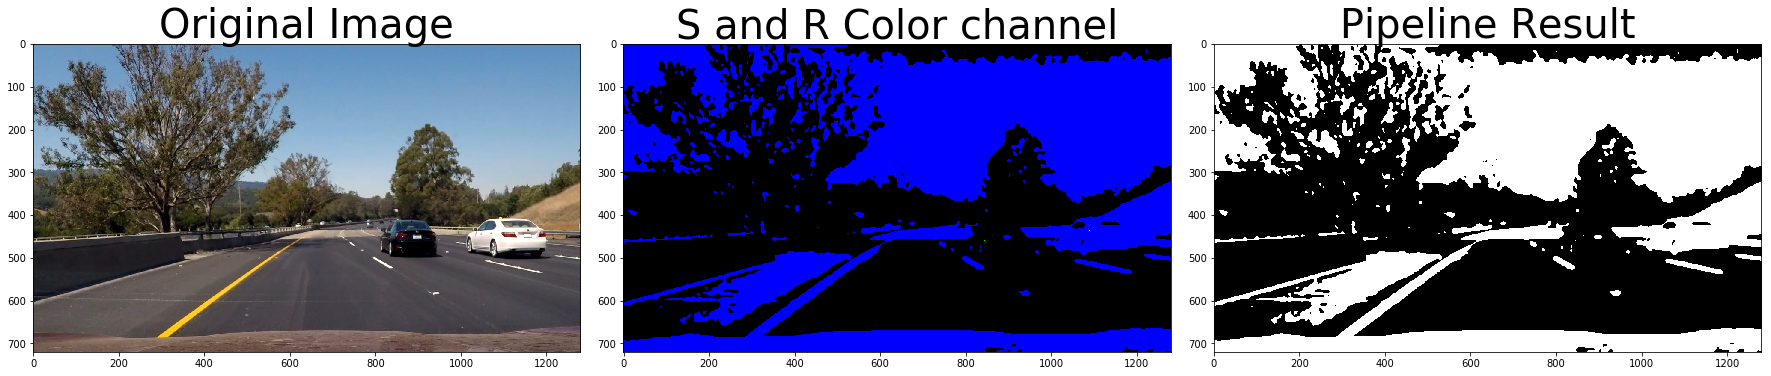

In [6]:
test_images=glob.glob('test_images/*.jpg')
test_out_image=[]
test_img_unwrap=[]
color_binary=[]
top_down_images_unwrap=[]
perspective_M_unwraps=[]
perspective_wrapped_image=[]
Mvin=[]
for fimg in test_images:
    
    img=mping.imread(fimg)
    kernel_size = 17
    blur_img = cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)
    
    
    test_out_image,color_binary=color_gradient(blur_img,sobel_kernel=31)
    
    test_img_unwrap.append(test_out_image)
    top_down_unwrap, perspective_M_unwrap,Mvin,undistorted = corners_unwarp_lane_lines(test_out_image, 9, 6, mtx, dist)

    top_down_images_unwrap.append(top_down_unwrap)
    perspective_wrapped_image.append(undistorted)
    perspective_M_unwraps.append(perspective_M_unwrap)
    
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)
    
    ax2.imshow(color_binary)
    ax2.set_title('S and R Color channel', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    ax3.imshow(test_out_image,cmap='gray')
    ax3.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
      
    


8
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


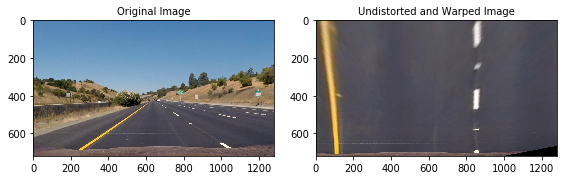

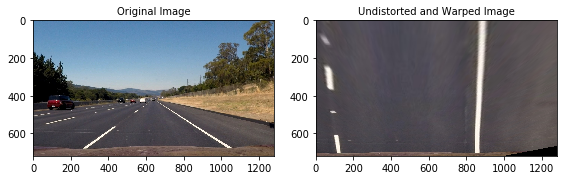

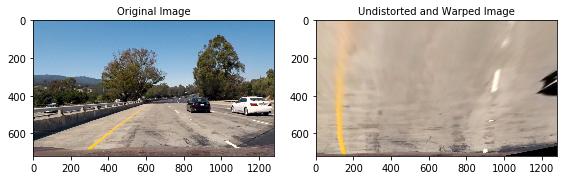

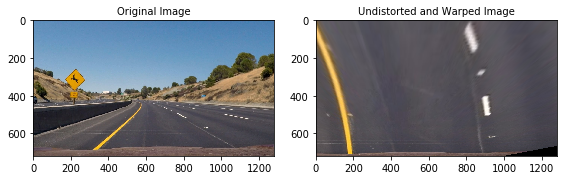

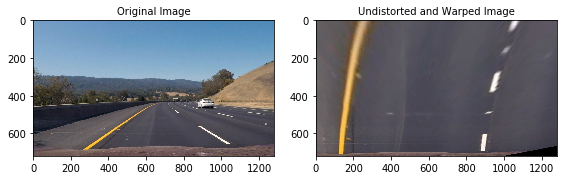

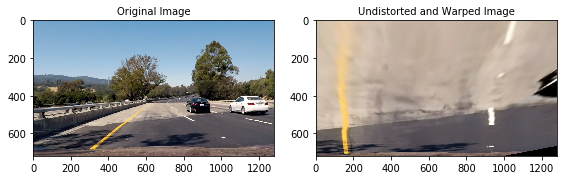

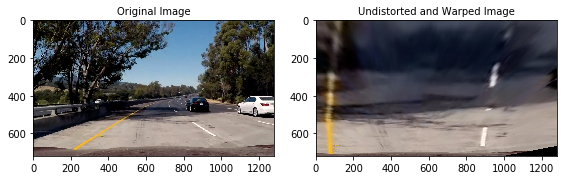

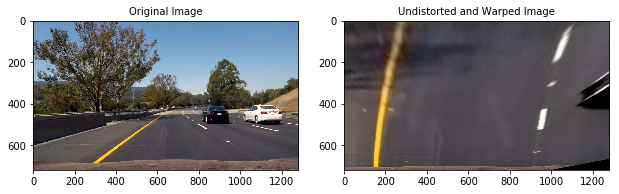

In [7]:
print(len(perspective_wrapped_image))
test_images=glob.glob('test_images/*.jpg')
for fimg in test_images:
    
    img=mping.imread(fimg)
    unwrap, perspective_M_unwrap,Mvin,undistorted = corners_unwarp_lane_lines(img, 9, 6, mtx, dist)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(unwrap)
    ax2.set_title('Undistorted and Warped Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

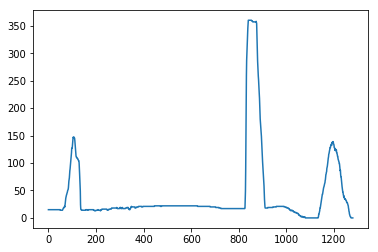

In [8]:
binary_warped=top_down_images_unwrap[1]

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint


nwindows = 9

window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)




In [9]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

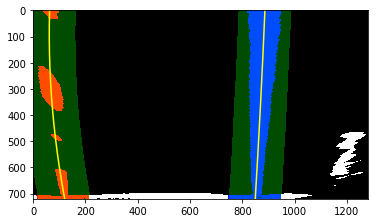

In [10]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

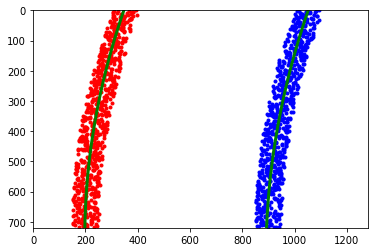

In [11]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [12]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1894.4795405335567 2060.846118624575


In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

621.9785084590372 m 674.7959878261925 m


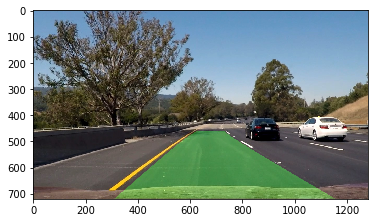

In [14]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Mvin, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(mping.imread(test_images[7]), 1, newwarp, 0.3, 0)
plt.imshow(result)

In [15]:
def find_lanes(binary_warped):
    
    #for binary_warped in top_down_images_unwrap:
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=1)
    #plt.plot(histogram)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)       
    
    return left_lane_inds,right_lane_inds

In [16]:
def pipelines(img):
    
    global left_fit
    global right_fit
    
    test_img_unwrap=[]
    color_binary=[]
    top_down_images_unwrap=[]
    perspective_M_unwraps=[]
    perspective_wrapped_image=[]
    Mvin=[]
    
    kernel_size = 15
    blur_img = cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)
    

    test_out_image,color_binary=color_gradient(blur_img,sobel_kernel=31)
    #print(test_out_image)
    test_img_unwrap.append(test_out_image)
    binary_warped, perspective_M_unwrap,Mvin,undistorted = corners_unwarp_lane_lines(test_out_image, 9, 6, mtx, dist)

    perspective_M_unwraps.append(perspective_M_unwrap)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    
    #binary_warped=img
    left_lane_inds,right_lane_inds=find_lanes(binary_warped)
    

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    margin = 100
    
    # Fit a second order polynomial to each
    if(np.all(lefty != None))|(np.all(leftx != None)):
        left_fit = np.polyfit(lefty, leftx, 2)
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    if(np.all(righty != None))|(np.all(rightx != None)):
        right_fit = np.polyfit(righty, rightx, 2)
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
 

    

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]



    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                          for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                            for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Mvin, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result
    

In [ ]:
import os
####code for test videos
if os.path.isdir("test_videos_output"):
    pass
else:
    os.mkdir("test_videos_output")
    

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    result = pipelines(image)
    return result
left_fit=[]
right_fit=[]
white_output = 'project_video_test.mp4'
clip1 = VideoFileClip("C:\\Users\\Vivek.Pathak01\\Desktop\\project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()

(1280, 720)
[MoviePy] >>>> Building video project_video_test.mp4
[MoviePy] Writing video project_video_test.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

(1280, 720)


  0%|                                                                                 | 1/1261 [00:00<13:15,  1.58it/s]

(1280, 720)


  0%|▏                                                                                | 2/1261 [00:01<13:37,  1.54it/s]

(1280, 720)


  0%|▏                                                                                | 3/1261 [00:02<14:25,  1.45it/s]

(1280, 720)


  0%|▎                                                                                | 4/1261 [00:02<14:03,  1.49it/s]

(1280, 720)


  0%|▎                                                                                | 5/1261 [00:03<13:32,  1.55it/s]

(1280, 720)


  0%|▍                                                                                | 6/1261 [00:03<12:31,  1.67it/s]

(1280, 720)


  1%|▍                                                                                | 7/1261 [00:04<11:46,  1.77it/s]

(1280, 720)


  1%|▌                                                                                | 8/1261 [00:04<11:14,  1.86it/s]

(1280, 720)


  1%|▌                                                                                | 9/1261 [00:05<10:49,  1.93it/s]

(1280, 720)


  1%|▋                                                                               | 10/1261 [00:06<12:24,  1.68it/s]

(1280, 720)


  1%|▋                                                                               | 11/1261 [00:06<13:40,  1.52it/s]

(1280, 720)


  1%|▊                                                                               | 12/1261 [00:07<13:15,  1.57it/s]

(1280, 720)


  1%|▊                                                                               | 13/1261 [00:08<13:14,  1.57it/s]

(1280, 720)


  1%|▉                                                                               | 14/1261 [00:08<12:29,  1.66it/s]

(1280, 720)


  1%|▉                                                                               | 15/1261 [00:09<12:02,  1.72it/s]

(1280, 720)


  1%|█                                                                               | 16/1261 [00:09<11:56,  1.74it/s]

(1280, 720)


  1%|█                                                                               | 17/1261 [00:10<11:30,  1.80it/s]

(1280, 720)


  1%|█▏                                                                              | 18/1261 [00:10<11:19,  1.83it/s]

(1280, 720)


  2%|█▏                                                                              | 19/1261 [00:11<10:58,  1.88it/s]

(1280, 720)


  2%|█▎                                                                              | 20/1261 [00:11<10:29,  1.97it/s]

(1280, 720)


  2%|█▎                                                                              | 21/1261 [00:12<10:14,  2.02it/s]

(1280, 720)


  2%|█▍                                                                              | 22/1261 [00:12<09:42,  2.13it/s]

(1280, 720)


  2%|█▍                                                                              | 23/1261 [00:12<09:26,  2.18it/s]

(1280, 720)


  2%|█▌                                                                              | 24/1261 [00:13<09:03,  2.28it/s]

(1280, 720)


  2%|█▌                                                                              | 25/1261 [00:13<08:49,  2.34it/s]

(1280, 720)


  2%|█▋                                                                              | 26/1261 [00:14<10:52,  1.89it/s]

(1280, 720)


  2%|█▋                                                                              | 27/1261 [00:15<11:12,  1.83it/s]

(1280, 720)


  2%|█▊                                                                              | 28/1261 [00:15<10:21,  1.98it/s]

(1280, 720)


  2%|█▊                                                                              | 29/1261 [00:15<09:53,  2.07it/s]

(1280, 720)


  2%|█▉                                                                              | 30/1261 [00:16<09:42,  2.11it/s]

(1280, 720)


  2%|█▉                                                                              | 31/1261 [00:16<09:32,  2.15it/s]

(1280, 720)


  3%|██                                                                              | 32/1261 [00:17<09:24,  2.18it/s]

(1280, 720)


  3%|██                                                                              | 33/1261 [00:17<09:23,  2.18it/s]

(1280, 720)


  3%|██▏                                                                             | 34/1261 [00:18<11:02,  1.85it/s]

(1280, 720)


  3%|██▏                                                                             | 35/1261 [00:18<10:30,  1.95it/s]

(1280, 720)


  3%|██▎                                                                             | 36/1261 [00:19<10:09,  2.01it/s]

(1280, 720)


  3%|██▎                                                                             | 37/1261 [00:19<09:41,  2.10it/s]

(1280, 720)


  3%|██▍                                                                             | 38/1261 [00:20<09:13,  2.21it/s]

(1280, 720)


  3%|██▍                                                                             | 39/1261 [00:20<09:00,  2.26it/s]

(1280, 720)


  3%|██▌                                                                             | 40/1261 [00:21<08:43,  2.33it/s]

(1280, 720)


  3%|██▌                                                                             | 41/1261 [00:21<08:36,  2.36it/s]

(1280, 720)


  3%|██▋                                                                             | 42/1261 [00:21<08:31,  2.38it/s]

(1280, 720)


  3%|██▋                                                                             | 43/1261 [00:22<08:34,  2.37it/s]

(1280, 720)


  3%|██▊                                                                             | 44/1261 [00:22<09:13,  2.20it/s]

(1280, 720)


  4%|██▊                                                                             | 45/1261 [00:23<09:45,  2.08it/s]

(1280, 720)


  4%|██▉                                                                             | 46/1261 [00:23<09:36,  2.11it/s]

(1280, 720)


  4%|██▉                                                                             | 47/1261 [00:24<10:14,  1.97it/s]

(1280, 720)


  4%|███                                                                             | 48/1261 [00:25<11:00,  1.84it/s]

(1280, 720)


  4%|███                                                                             | 49/1261 [00:25<13:07,  1.54it/s]

(1280, 720)


  4%|███▏                                                                            | 50/1261 [00:26<14:50,  1.36it/s]

(1280, 720)


  4%|███▏                                                                            | 51/1261 [00:27<14:01,  1.44it/s]

(1280, 720)


  4%|███▎                                                                            | 52/1261 [00:28<14:24,  1.40it/s]

(1280, 720)


  4%|███▎                                                                            | 53/1261 [00:28<13:28,  1.49it/s]

(1280, 720)


  4%|███▍                                                                            | 54/1261 [00:29<12:38,  1.59it/s]

(1280, 720)


  4%|███▍                                                                            | 55/1261 [00:29<12:00,  1.67it/s]

(1280, 720)


  4%|███▌                                                                            | 56/1261 [00:30<11:37,  1.73it/s]

(1280, 720)


  5%|███▌                                                                            | 57/1261 [00:30<11:09,  1.80it/s]

(1280, 720)


  5%|███▋                                                                            | 58/1261 [00:31<10:43,  1.87it/s]

(1280, 720)


  5%|███▋                                                                            | 59/1261 [00:31<10:27,  1.92it/s]

(1280, 720)


  5%|███▊                                                                            | 60/1261 [00:32<10:16,  1.95it/s]

(1280, 720)


  5%|███▊                                                                            | 61/1261 [00:32<10:19,  1.94it/s]

(1280, 720)


  5%|███▉                                                                            | 62/1261 [00:33<11:16,  1.77it/s]

(1280, 720)


  5%|███▉                                                                            | 63/1261 [00:34<11:42,  1.71it/s]

(1280, 720)


  5%|████                                                                            | 64/1261 [00:34<11:08,  1.79it/s]

(1280, 720)


  5%|████                                                                            | 65/1261 [00:35<10:53,  1.83it/s]

(1280, 720)


  5%|████▏                                                                           | 66/1261 [00:35<11:15,  1.77it/s]

(1280, 720)


  5%|████▎                                                                           | 67/1261 [00:36<10:22,  1.92it/s]

(1280, 720)


  5%|████▎                                                                           | 68/1261 [00:36<09:50,  2.02it/s]

(1280, 720)


  5%|████▍                                                                           | 69/1261 [00:37<10:29,  1.89it/s]

(1280, 720)


  6%|████▍                                                                           | 70/1261 [00:37<10:20,  1.92it/s]

(1280, 720)


  6%|████▌                                                                           | 71/1261 [00:38<09:42,  2.04it/s]

(1280, 720)


  6%|████▌                                                                           | 72/1261 [00:38<09:25,  2.10it/s]

(1280, 720)


  6%|████▋                                                                           | 73/1261 [00:39<08:59,  2.20it/s]

(1280, 720)


  6%|████▋                                                                           | 74/1261 [00:39<08:55,  2.22it/s]

(1280, 720)


  6%|████▊                                                                           | 75/1261 [00:39<08:54,  2.22it/s]

(1280, 720)


  6%|████▊                                                                           | 76/1261 [00:40<08:51,  2.23it/s]

(1280, 720)


  6%|████▉                                                                           | 77/1261 [00:41<10:44,  1.84it/s]

(1280, 720)


  6%|████▉                                                                           | 78/1261 [00:41<12:26,  1.58it/s]

(1280, 720)


  6%|█████                                                                           | 79/1261 [00:42<13:03,  1.51it/s]

(1280, 720)


  6%|█████                                                                           | 80/1261 [00:43<11:35,  1.70it/s]

(1280, 720)


  6%|█████▏                                                                          | 81/1261 [00:43<10:35,  1.86it/s]

(1280, 720)


  7%|█████▏                                                                          | 82/1261 [00:43<09:48,  2.00it/s]

(1280, 720)


  7%|█████▎                                                                          | 83/1261 [00:44<09:16,  2.12it/s]

(1280, 720)


  7%|█████▎                                                                          | 84/1261 [00:44<08:58,  2.18it/s]

(1280, 720)


  7%|█████▍                                                                          | 85/1261 [00:45<09:00,  2.18it/s]

(1280, 720)


  7%|█████▍                                                                          | 86/1261 [00:45<08:44,  2.24it/s]

(1280, 720)


  7%|█████▌                                                                          | 87/1261 [00:46<08:30,  2.30it/s]

(1280, 720)


  7%|█████▌                                                                          | 88/1261 [00:46<08:49,  2.22it/s]

(1280, 720)


  7%|█████▋                                                                          | 89/1261 [00:46<08:32,  2.29it/s]

(1280, 720)


  7%|█████▋                                                                          | 90/1261 [00:47<08:29,  2.30it/s]

(1280, 720)


  7%|█████▊                                                                          | 91/1261 [00:47<08:32,  2.28it/s]

(1280, 720)


  7%|█████▊                                                                          | 92/1261 [00:48<10:29,  1.86it/s]

(1280, 720)


  7%|█████▉                                                                          | 93/1261 [00:49<10:02,  1.94it/s]

(1280, 720)


  7%|█████▉                                                                          | 94/1261 [00:49<10:13,  1.90it/s]

(1280, 720)


  8%|██████                                                                          | 95/1261 [00:50<09:46,  1.99it/s]

(1280, 720)


  8%|██████                                                                          | 96/1261 [00:51<13:17,  1.46it/s]

(1280, 720)


  8%|██████▏                                                                         | 97/1261 [00:51<11:56,  1.63it/s]

(1280, 720)


  8%|██████▏                                                                         | 98/1261 [00:52<11:03,  1.75it/s]

(1280, 720)


  8%|██████▎                                                                         | 99/1261 [00:52<10:14,  1.89it/s]

(1280, 720)


  8%|██████▎                                                                        | 100/1261 [00:52<09:44,  1.99it/s]

(1280, 720)


  8%|██████▎                                                                        | 101/1261 [00:53<09:26,  2.05it/s]

(1280, 720)


  8%|██████▍                                                                        | 102/1261 [00:53<09:08,  2.11it/s]

(1280, 720)


  8%|██████▍                                                                        | 103/1261 [00:54<09:14,  2.09it/s]

(1280, 720)


  8%|██████▌                                                                        | 104/1261 [00:54<09:05,  2.12it/s]

(1280, 720)


  8%|██████▌                                                                        | 105/1261 [00:55<08:45,  2.20it/s]

(1280, 720)


  8%|██████▋                                                                        | 106/1261 [00:55<08:42,  2.21it/s]

(1280, 720)


  8%|██████▋                                                                        | 107/1261 [00:56<08:53,  2.16it/s]

(1280, 720)


  9%|██████▊                                                                        | 108/1261 [00:56<09:07,  2.10it/s]

(1280, 720)


  9%|██████▊                                                                        | 109/1261 [00:57<09:04,  2.11it/s]

(1280, 720)


  9%|██████▉                                                                        | 110/1261 [00:57<09:43,  1.97it/s]

(1280, 720)


  9%|██████▉                                                                        | 111/1261 [00:58<10:13,  1.88it/s]

(1280, 720)


  9%|███████                                                                        | 112/1261 [00:59<12:13,  1.57it/s]

(1280, 720)


  9%|███████                                                                        | 113/1261 [00:59<11:50,  1.62it/s]

(1280, 720)


  9%|███████▏                                                                       | 114/1261 [01:00<10:39,  1.79it/s]

(1280, 720)


  9%|███████▏                                                                       | 115/1261 [01:00<09:44,  1.96it/s]

(1280, 720)


  9%|███████▎                                                                       | 116/1261 [01:01<09:36,  1.98it/s]

(1280, 720)


  9%|███████▎                                                                       | 117/1261 [01:01<10:45,  1.77it/s]

(1280, 720)


  9%|███████▍                                                                       | 118/1261 [01:02<12:05,  1.57it/s]

(1280, 720)


  9%|███████▍                                                                       | 119/1261 [01:03<12:12,  1.56it/s]

(1280, 720)


 10%|███████▌                                                                       | 120/1261 [01:04<13:39,  1.39it/s]

(1280, 720)


 10%|███████▌                                                                       | 121/1261 [01:05<14:39,  1.30it/s]

(1280, 720)


 10%|███████▋                                                                       | 122/1261 [01:05<14:39,  1.30it/s]

(1280, 720)


 10%|███████▋                                                                       | 123/1261 [01:06<14:29,  1.31it/s]

(1280, 720)


 10%|███████▊                                                                       | 124/1261 [01:07<14:35,  1.30it/s]

(1280, 720)


 10%|███████▊                                                                       | 125/1261 [01:08<14:26,  1.31it/s]

(1280, 720)


 10%|███████▉                                                                       | 126/1261 [01:08<13:50,  1.37it/s]

(1280, 720)


 10%|███████▉                                                                       | 127/1261 [01:09<12:29,  1.51it/s]

(1280, 720)


 10%|████████                                                                       | 128/1261 [01:09<11:03,  1.71it/s]

(1280, 720)


 10%|████████                                                                       | 129/1261 [01:10<10:50,  1.74it/s]

(1280, 720)


 10%|████████▏                                                                      | 130/1261 [01:10<10:17,  1.83it/s]

(1280, 720)


 10%|████████▏                                                                      | 131/1261 [01:11<10:10,  1.85it/s]

(1280, 720)


 10%|████████▎                                                                      | 132/1261 [01:11<09:54,  1.90it/s]

(1280, 720)


 11%|████████▎                                                                      | 133/1261 [01:12<10:07,  1.86it/s]

(1280, 720)


 11%|████████▍                                                                      | 134/1261 [01:12<10:45,  1.75it/s]

(1280, 720)


 11%|████████▍                                                                      | 135/1261 [01:13<11:31,  1.63it/s]

(1280, 720)


 11%|████████▌                                                                      | 136/1261 [01:14<11:46,  1.59it/s]

(1280, 720)


 11%|████████▌                                                                      | 137/1261 [01:14<12:12,  1.53it/s]

(1280, 720)


 11%|████████▋                                                                      | 138/1261 [01:15<12:13,  1.53it/s]

(1280, 720)


 11%|████████▋                                                                      | 139/1261 [01:16<12:23,  1.51it/s]

(1280, 720)


 11%|████████▊                                                                      | 140/1261 [01:16<11:01,  1.69it/s]

(1280, 720)


 11%|████████▊                                                                      | 141/1261 [01:17<09:53,  1.89it/s]

(1280, 720)


 11%|████████▉                                                                      | 142/1261 [01:17<09:47,  1.90it/s]

(1280, 720)


 11%|████████▉                                                                      | 143/1261 [01:18<10:27,  1.78it/s]

(1280, 720)


 11%|█████████                                                                      | 144/1261 [01:18<11:07,  1.67it/s]

(1280, 720)


 11%|█████████                                                                      | 145/1261 [01:19<11:00,  1.69it/s]

(1280, 720)


 12%|█████████▏                                                                     | 146/1261 [01:19<09:57,  1.87it/s]

(1280, 720)


 12%|█████████▏                                                                     | 147/1261 [01:20<09:17,  2.00it/s]

(1280, 720)


 12%|█████████▎                                                                     | 148/1261 [01:20<08:47,  2.11it/s]

(1280, 720)


 12%|█████████▎                                                                     | 149/1261 [01:21<08:23,  2.21it/s]

(1280, 720)


 12%|█████████▍                                                                     | 150/1261 [01:21<08:10,  2.26it/s]

(1280, 720)


 12%|█████████▍                                                                     | 151/1261 [01:22<08:09,  2.27it/s]

(1280, 720)


 12%|█████████▌                                                                     | 152/1261 [01:22<08:13,  2.25it/s]

(1280, 720)


 12%|█████████▌                                                                     | 153/1261 [01:23<09:03,  2.04it/s]

(1280, 720)


 12%|█████████▋                                                                     | 154/1261 [01:23<09:01,  2.04it/s]

(1280, 720)


 12%|█████████▋                                                                     | 155/1261 [01:23<08:33,  2.16it/s]

(1280, 720)


 12%|█████████▊                                                                     | 156/1261 [01:24<08:12,  2.24it/s]

(1280, 720)


 12%|█████████▊                                                                     | 157/1261 [01:24<07:56,  2.32it/s]

(1280, 720)


 13%|█████████▉                                                                     | 158/1261 [01:25<07:47,  2.36it/s]

(1280, 720)


 13%|█████████▉                                                                     | 159/1261 [01:25<07:36,  2.41it/s]

(1280, 720)


 13%|██████████                                                                     | 160/1261 [01:25<07:34,  2.42it/s]

(1280, 720)


 13%|██████████                                                                     | 161/1261 [01:26<07:28,  2.45it/s]

(1280, 720)


 13%|██████████▏                                                                    | 162/1261 [01:26<07:27,  2.46it/s]

(1280, 720)


 13%|██████████▏                                                                    | 163/1261 [01:27<07:25,  2.46it/s]

(1280, 720)


 13%|██████████▎                                                                    | 164/1261 [01:27<07:23,  2.47it/s]

(1280, 720)


 13%|██████████▎                                                                    | 165/1261 [01:28<07:21,  2.48it/s]

(1280, 720)


 13%|██████████▍                                                                    | 166/1261 [01:28<07:18,  2.50it/s]

(1280, 720)


 13%|██████████▍                                                                    | 167/1261 [01:28<07:22,  2.47it/s]

(1280, 720)


 13%|██████████▌                                                                    | 168/1261 [01:29<07:38,  2.38it/s]

(1280, 720)


 13%|██████████▌                                                                    | 169/1261 [01:29<07:46,  2.34it/s]

(1280, 720)


 13%|██████████▋                                                                    | 170/1261 [01:30<09:21,  1.94it/s]

(1280, 720)


 14%|██████████▋                                                                    | 171/1261 [01:30<08:55,  2.04it/s]

(1280, 720)


 14%|██████████▊                                                                    | 172/1261 [01:31<08:30,  2.13it/s]

(1280, 720)


 14%|██████████▊                                                                    | 173/1261 [01:31<08:06,  2.24it/s]

(1280, 720)


 14%|██████████▉                                                                    | 174/1261 [01:32<07:56,  2.28it/s]

(1280, 720)


 14%|██████████▉                                                                    | 175/1261 [01:32<07:45,  2.33it/s]

(1280, 720)


 14%|███████████                                                                    | 176/1261 [01:32<07:35,  2.38it/s]

(1280, 720)


 14%|███████████                                                                    | 177/1261 [01:33<07:32,  2.40it/s]

(1280, 720)


 14%|███████████▏                                                                   | 178/1261 [01:33<07:28,  2.41it/s]

(1280, 720)


 14%|███████████▏                                                                   | 179/1261 [01:34<07:26,  2.43it/s]

(1280, 720)


 14%|███████████▎                                                                   | 180/1261 [01:34<07:22,  2.44it/s]

(1280, 720)


 14%|███████████▎                                                                   | 181/1261 [01:34<07:19,  2.46it/s]

(1280, 720)


 14%|███████████▍                                                                   | 182/1261 [01:35<07:15,  2.48it/s]

(1280, 720)


 15%|███████████▍                                                                   | 183/1261 [01:35<07:15,  2.48it/s]

(1280, 720)


 15%|███████████▌                                                                   | 184/1261 [01:36<07:21,  2.44it/s]

(1280, 720)


 15%|███████████▌                                                                   | 185/1261 [01:36<07:32,  2.38it/s]

(1280, 720)


 15%|███████████▋                                                                   | 186/1261 [01:37<07:30,  2.38it/s]

(1280, 720)


 15%|███████████▋                                                                   | 187/1261 [01:37<08:25,  2.12it/s]

(1280, 720)


 15%|███████████▊                                                                   | 188/1261 [01:38<08:46,  2.04it/s]

(1280, 720)


 15%|███████████▊                                                                   | 189/1261 [01:38<08:23,  2.13it/s]

(1280, 720)


 15%|███████████▉                                                                   | 190/1261 [01:38<08:03,  2.21it/s]

(1280, 720)


 15%|███████████▉                                                                   | 191/1261 [01:39<07:53,  2.26it/s]

(1280, 720)


 15%|████████████                                                                   | 192/1261 [01:39<07:34,  2.35it/s]

(1280, 720)


 15%|████████████                                                                   | 193/1261 [01:40<07:30,  2.37it/s]

(1280, 720)


 15%|████████████▏                                                                  | 194/1261 [01:40<07:28,  2.38it/s]

(1280, 720)


 15%|████████████▏                                                                  | 195/1261 [01:41<07:26,  2.39it/s]

(1280, 720)


 16%|████████████▎                                                                  | 196/1261 [01:41<07:22,  2.41it/s]

(1280, 720)


 16%|████████████▎                                                                  | 197/1261 [01:41<07:21,  2.41it/s]

(1280, 720)


 16%|████████████▍                                                                  | 198/1261 [01:42<07:19,  2.42it/s]

(1280, 720)


 16%|████████████▍                                                                  | 199/1261 [01:42<07:13,  2.45it/s]

(1280, 720)


 16%|████████████▌                                                                  | 200/1261 [01:43<07:15,  2.43it/s]

(1280, 720)


 16%|████████████▌                                                                  | 201/1261 [01:43<07:11,  2.46it/s]

(1280, 720)


 16%|████████████▋                                                                  | 202/1261 [01:43<07:30,  2.35it/s]

(1280, 720)


 16%|████████████▋                                                                  | 203/1261 [01:44<07:35,  2.32it/s]

(1280, 720)


 16%|████████████▊                                                                  | 204/1261 [01:45<09:20,  1.89it/s]

(1280, 720)


 16%|████████████▊                                                                  | 205/1261 [01:45<08:59,  1.96it/s]

(1280, 720)


 16%|████████████▉                                                                  | 206/1261 [01:46<08:26,  2.08it/s]

(1280, 720)


 16%|████████████▉                                                                  | 207/1261 [01:46<08:04,  2.17it/s]

(1280, 720)


 16%|█████████████                                                                  | 208/1261 [01:46<07:49,  2.24it/s]

(1280, 720)


 17%|█████████████                                                                  | 209/1261 [01:47<07:34,  2.31it/s]

(1280, 720)


 17%|█████████████▏                                                                 | 210/1261 [01:47<07:26,  2.36it/s]

(1280, 720)


 17%|█████████████▏                                                                 | 211/1261 [01:48<07:19,  2.39it/s]

(1280, 720)


 17%|█████████████▎                                                                 | 212/1261 [01:48<07:11,  2.43it/s]

(1280, 720)


 17%|█████████████▎                                                                 | 213/1261 [01:48<07:14,  2.41it/s]

(1280, 720)


 17%|█████████████▍                                                                 | 214/1261 [01:49<07:06,  2.46it/s]

(1280, 720)


 17%|█████████████▍                                                                 | 215/1261 [01:49<07:02,  2.47it/s]

(1280, 720)


 17%|█████████████▌                                                                 | 216/1261 [01:50<06:57,  2.50it/s]

(1280, 720)


 17%|█████████████▌                                                                 | 217/1261 [01:50<06:59,  2.49it/s]

(1280, 720)


 17%|█████████████▋                                                                 | 218/1261 [01:50<07:07,  2.44it/s]

(1280, 720)


 17%|█████████████▋                                                                 | 219/1261 [01:51<07:24,  2.35it/s]

(1280, 720)


 17%|█████████████▊                                                                 | 220/1261 [01:51<08:02,  2.16it/s]

(1280, 720)


 18%|█████████████▊                                                                 | 221/1261 [01:52<08:42,  1.99it/s]

(1280, 720)


 18%|█████████████▉                                                                 | 222/1261 [01:53<08:49,  1.96it/s]

(1280, 720)


 18%|█████████████▉                                                                 | 223/1261 [01:53<08:25,  2.05it/s]

(1280, 720)


 18%|██████████████                                                                 | 224/1261 [01:53<08:03,  2.14it/s]

(1280, 720)


 18%|██████████████                                                                 | 225/1261 [01:54<07:56,  2.17it/s]

(1280, 720)


 18%|██████████████▏                                                                | 226/1261 [01:54<09:01,  1.91it/s]

(1280, 720)


 18%|██████████████▏                                                                | 227/1261 [01:55<09:31,  1.81it/s]

(1280, 720)


 18%|██████████████▎                                                                | 228/1261 [01:56<08:57,  1.92it/s]

(1280, 720)


 18%|██████████████▎                                                                | 229/1261 [01:56<08:53,  1.94it/s]

(1280, 720)


 18%|██████████████▍                                                                | 230/1261 [01:57<08:29,  2.02it/s]

(1280, 720)


 18%|██████████████▍                                                                | 231/1261 [01:57<08:04,  2.13it/s]

(1280, 720)


 18%|██████████████▌                                                                | 232/1261 [01:57<07:48,  2.20it/s]

(1280, 720)


 18%|██████████████▌                                                                | 233/1261 [01:58<07:45,  2.21it/s]

(1280, 720)


 19%|██████████████▋                                                                | 234/1261 [01:58<07:44,  2.21it/s]

(1280, 720)


 19%|██████████████▋                                                                | 235/1261 [01:59<08:20,  2.05it/s]

(1280, 720)


 19%|██████████████▊                                                                | 236/1261 [01:59<08:27,  2.02it/s]

(1280, 720)


 19%|██████████████▊                                                                | 237/1261 [02:00<08:01,  2.13it/s]

(1280, 720)


 19%|██████████████▉                                                                | 238/1261 [02:00<07:57,  2.14it/s]

(1280, 720)


 19%|██████████████▉                                                                | 239/1261 [02:01<08:07,  2.10it/s]

(1280, 720)


 19%|███████████████                                                                | 240/1261 [02:01<08:08,  2.09it/s]

(1280, 720)


 19%|███████████████                                                                | 241/1261 [02:02<08:08,  2.09it/s]

(1280, 720)


 19%|███████████████▏                                                               | 242/1261 [02:02<08:12,  2.07it/s]

(1280, 720)


 19%|███████████████▏                                                               | 243/1261 [02:03<07:58,  2.13it/s]

(1280, 720)


 19%|███████████████▎                                                               | 244/1261 [02:03<07:34,  2.24it/s]

(1280, 720)


 19%|███████████████▎                                                               | 245/1261 [02:03<07:33,  2.24it/s]

(1280, 720)


 20%|███████████████▍                                                               | 246/1261 [02:04<07:44,  2.18it/s]

(1280, 720)


 20%|███████████████▍                                                               | 247/1261 [02:04<07:33,  2.24it/s]

(1280, 720)


 20%|███████████████▌                                                               | 248/1261 [02:05<07:21,  2.29it/s]

(1280, 720)


 20%|███████████████▌                                                               | 249/1261 [02:05<07:48,  2.16it/s]

(1280, 720)


 20%|███████████████▋                                                               | 250/1261 [02:06<07:46,  2.17it/s]

(1280, 720)


 20%|███████████████▋                                                               | 251/1261 [02:06<08:17,  2.03it/s]

(1280, 720)


 20%|███████████████▊                                                               | 252/1261 [02:07<08:28,  1.98it/s]

(1280, 720)


 20%|███████████████▊                                                               | 253/1261 [02:07<07:57,  2.11it/s]

(1280, 720)


 20%|███████████████▉                                                               | 254/1261 [02:08<07:39,  2.19it/s]

(1280, 720)


 20%|███████████████▉                                                               | 255/1261 [02:08<07:23,  2.27it/s]

(1280, 720)


 20%|████████████████                                                               | 256/1261 [02:08<07:08,  2.35it/s]

(1280, 720)


 20%|████████████████                                                               | 257/1261 [02:09<06:52,  2.43it/s]

(1280, 720)


 20%|████████████████▏                                                              | 258/1261 [02:09<06:46,  2.47it/s]

(1280, 720)


 21%|████████████████▏                                                              | 259/1261 [02:10<06:40,  2.50it/s]

(1280, 720)


 21%|████████████████▎                                                              | 260/1261 [02:10<06:36,  2.53it/s]

(1280, 720)


 21%|████████████████▎                                                              | 261/1261 [02:10<06:43,  2.48it/s]

(1280, 720)


 21%|████████████████▍                                                              | 262/1261 [02:11<06:36,  2.52it/s]

(1280, 720)


 21%|████████████████▍                                                              | 263/1261 [02:11<06:33,  2.53it/s]

(1280, 720)


 21%|████████████████▌                                                              | 264/1261 [02:12<06:27,  2.57it/s]

(1280, 720)


 21%|████████████████▌                                                              | 265/1261 [02:12<06:27,  2.57it/s]

(1280, 720)


 21%|████████████████▋                                                              | 266/1261 [02:12<06:27,  2.57it/s]

(1280, 720)


 21%|████████████████▋                                                              | 267/1261 [02:13<06:36,  2.50it/s]

(1280, 720)


 21%|████████████████▊                                                              | 268/1261 [02:13<07:34,  2.18it/s]

(1280, 720)


 21%|████████████████▊                                                              | 269/1261 [02:14<07:32,  2.19it/s]

(1280, 720)


 21%|████████████████▉                                                              | 270/1261 [02:14<07:17,  2.27it/s]

(1280, 720)


 21%|████████████████▉                                                              | 271/1261 [02:15<07:07,  2.32it/s]

(1280, 720)


 22%|█████████████████                                                              | 272/1261 [02:15<06:54,  2.39it/s]

(1280, 720)


 22%|█████████████████                                                              | 273/1261 [02:15<06:50,  2.41it/s]

(1280, 720)


 22%|█████████████████▏                                                             | 274/1261 [02:16<07:00,  2.35it/s]

(1280, 720)


 22%|█████████████████▏                                                             | 275/1261 [02:16<06:54,  2.38it/s]

(1280, 720)


 22%|█████████████████▎                                                             | 276/1261 [02:17<07:20,  2.24it/s]

(1280, 720)


 22%|█████████████████▎                                                             | 277/1261 [02:17<07:33,  2.17it/s]

(1280, 720)


 22%|█████████████████▍                                                             | 278/1261 [02:18<07:41,  2.13it/s]

(1280, 720)


 22%|█████████████████▍                                                             | 279/1261 [02:18<07:35,  2.16it/s]

(1280, 720)


 22%|█████████████████▌                                                             | 280/1261 [02:19<07:16,  2.25it/s]

(1280, 720)


 22%|█████████████████▌                                                             | 281/1261 [02:19<06:57,  2.35it/s]

(1280, 720)


 22%|█████████████████▋                                                             | 282/1261 [02:19<07:03,  2.31it/s]

(1280, 720)


 22%|█████████████████▋                                                             | 283/1261 [02:20<07:09,  2.28it/s]

(1280, 720)


 23%|█████████████████▊                                                             | 284/1261 [02:20<07:44,  2.10it/s]

(1280, 720)


 23%|█████████████████▊                                                             | 285/1261 [02:21<07:56,  2.05it/s]

(1280, 720)


 23%|█████████████████▉                                                             | 286/1261 [02:21<07:40,  2.12it/s]

(1280, 720)


 23%|█████████████████▉                                                             | 287/1261 [02:22<07:48,  2.08it/s]

(1280, 720)


 23%|██████████████████                                                             | 288/1261 [02:23<10:45,  1.51it/s]

(1280, 720)


 23%|██████████████████                                                             | 289/1261 [02:24<10:48,  1.50it/s]

(1280, 720)


 23%|██████████████████▏                                                            | 290/1261 [02:24<10:38,  1.52it/s]

(1280, 720)


 23%|██████████████████▏                                                            | 291/1261 [02:25<11:50,  1.37it/s]

(1280, 720)


 23%|██████████████████▎                                                            | 292/1261 [02:26<12:13,  1.32it/s]

(1280, 720)


 23%|██████████████████▎                                                            | 293/1261 [02:27<10:51,  1.49it/s]

(1280, 720)


 23%|██████████████████▍                                                            | 294/1261 [02:27<10:09,  1.59it/s]

(1280, 720)


 23%|██████████████████▍                                                            | 295/1261 [02:29<18:30,  1.15s/it]

(1280, 720)


 23%|██████████████████▌                                                            | 296/1261 [02:30<16:04,  1.00it/s]

(1280, 720)


 24%|██████████████████▌                                                            | 297/1261 [02:31<13:28,  1.19it/s]

(1280, 720)


 24%|██████████████████▋                                                            | 298/1261 [02:31<11:22,  1.41it/s]

(1280, 720)


 24%|██████████████████▋                                                            | 299/1261 [02:31<09:53,  1.62it/s]

(1280, 720)


 24%|██████████████████▊                                                            | 300/1261 [02:32<09:53,  1.62it/s]

(1280, 720)


 24%|██████████████████▊                                                            | 301/1261 [02:32<08:56,  1.79it/s]

(1280, 720)


 24%|██████████████████▉                                                            | 302/1261 [02:33<08:16,  1.93it/s]

(1280, 720)


 24%|██████████████████▉                                                            | 303/1261 [02:33<07:52,  2.03it/s]

(1280, 720)


 24%|███████████████████                                                            | 304/1261 [02:34<08:54,  1.79it/s]

(1280, 720)


 24%|███████████████████                                                            | 305/1261 [02:34<08:13,  1.94it/s]

(1280, 720)


 24%|███████████████████▏                                                           | 306/1261 [02:35<07:49,  2.03it/s]

(1280, 720)


 24%|███████████████████▏                                                           | 307/1261 [02:35<07:32,  2.11it/s]

(1280, 720)


 24%|███████████████████▎                                                           | 308/1261 [02:36<07:23,  2.15it/s]

(1280, 720)


 25%|███████████████████▎                                                           | 309/1261 [02:36<07:23,  2.15it/s]

(1280, 720)


 25%|███████████████████▍                                                           | 310/1261 [02:37<07:32,  2.10it/s]

(1280, 720)


 25%|███████████████████▍                                                           | 311/1261 [02:37<08:21,  1.89it/s]

(1280, 720)


 25%|███████████████████▌                                                           | 312/1261 [02:38<08:06,  1.95it/s]

(1280, 720)


 25%|███████████████████▌                                                           | 313/1261 [02:38<07:47,  2.03it/s]

(1280, 720)


 25%|███████████████████▋                                                           | 314/1261 [02:39<07:28,  2.11it/s]

(1280, 720)


 25%|███████████████████▋                                                           | 315/1261 [02:39<07:09,  2.20it/s]

(1280, 720)


 25%|███████████████████▊                                                           | 316/1261 [02:39<06:53,  2.29it/s]

(1280, 720)


 25%|███████████████████▊                                                           | 317/1261 [02:40<06:57,  2.26it/s]

(1280, 720)


 25%|███████████████████▉                                                           | 318/1261 [02:40<06:47,  2.32it/s]

(1280, 720)


 25%|███████████████████▉                                                           | 319/1261 [02:41<08:50,  1.77it/s]

(1280, 720)


 25%|████████████████████                                                           | 320/1261 [02:42<08:05,  1.94it/s]

(1280, 720)


 25%|████████████████████                                                           | 321/1261 [02:42<08:59,  1.74it/s]

(1280, 720)


 26%|████████████████████▏                                                          | 322/1261 [02:43<08:15,  1.89it/s]

(1280, 720)


 26%|████████████████████▏                                                          | 323/1261 [02:43<07:57,  1.96it/s]

(1280, 720)


 26%|████████████████████▎                                                          | 324/1261 [02:44<08:00,  1.95it/s]

(1280, 720)


 26%|████████████████████▎                                                          | 325/1261 [02:44<07:54,  1.97it/s]

(1280, 720)


 26%|████████████████████▍                                                          | 326/1261 [02:45<08:23,  1.86it/s]

(1280, 720)


 26%|████████████████████▍                                                          | 327/1261 [02:45<08:27,  1.84it/s]

(1280, 720)


 26%|████████████████████▌                                                          | 328/1261 [02:46<08:15,  1.88it/s]

(1280, 720)


 26%|████████████████████▌                                                          | 329/1261 [02:46<07:44,  2.01it/s]

(1280, 720)


 26%|████████████████████▋                                                          | 330/1261 [02:47<07:19,  2.12it/s]

(1280, 720)


 26%|████████████████████▋                                                          | 331/1261 [02:47<07:00,  2.21it/s]

(1280, 720)


 26%|████████████████████▊                                                          | 332/1261 [02:47<06:47,  2.28it/s]

(1280, 720)


 26%|████████████████████▊                                                          | 333/1261 [02:48<06:35,  2.35it/s]

(1280, 720)


 26%|████████████████████▉                                                          | 334/1261 [02:48<06:29,  2.38it/s]

(1280, 720)


 27%|████████████████████▉                                                          | 335/1261 [02:49<06:24,  2.41it/s]

(1280, 720)


 27%|█████████████████████                                                          | 336/1261 [02:49<06:21,  2.42it/s]

(1280, 720)


 27%|█████████████████████                                                          | 337/1261 [02:49<06:15,  2.46it/s]

(1280, 720)


 27%|█████████████████████▏                                                         | 338/1261 [02:50<06:15,  2.46it/s]

(1280, 720)


 27%|█████████████████████▏                                                         | 339/1261 [02:50<06:15,  2.46it/s]

(1280, 720)


 27%|█████████████████████▎                                                         | 340/1261 [02:51<06:18,  2.43it/s]

(1280, 720)


 27%|█████████████████████▎                                                         | 341/1261 [02:51<06:30,  2.36it/s]

(1280, 720)


 27%|█████████████████████▍                                                         | 342/1261 [02:52<07:16,  2.11it/s]

(1280, 720)


 27%|█████████████████████▍                                                         | 343/1261 [02:52<07:31,  2.03it/s]

(1280, 720)


 27%|█████████████████████▌                                                         | 344/1261 [02:53<07:15,  2.10it/s]

(1280, 720)


 27%|█████████████████████▌                                                         | 345/1261 [02:53<06:56,  2.20it/s]

(1280, 720)


 27%|█████████████████████▋                                                         | 346/1261 [02:54<06:42,  2.27it/s]

(1280, 720)


 28%|█████████████████████▋                                                         | 347/1261 [02:54<06:32,  2.33it/s]

(1280, 720)


 28%|█████████████████████▊                                                         | 348/1261 [02:54<06:26,  2.36it/s]

(1280, 720)


 28%|█████████████████████▊                                                         | 349/1261 [02:55<06:20,  2.39it/s]

(1280, 720)


 28%|█████████████████████▉                                                         | 350/1261 [02:55<06:17,  2.41it/s]

(1280, 720)


 28%|█████████████████████▉                                                         | 351/1261 [02:56<06:14,  2.43it/s]

(1280, 720)


 28%|██████████████████████                                                         | 352/1261 [02:56<06:11,  2.45it/s]

(1280, 720)


 28%|██████████████████████                                                         | 353/1261 [02:56<06:18,  2.40it/s]

(1280, 720)


 28%|██████████████████████▏                                                        | 354/1261 [02:57<06:19,  2.39it/s]

(1280, 720)


 28%|██████████████████████▏                                                        | 355/1261 [02:57<06:11,  2.44it/s]

(1280, 720)


 28%|██████████████████████▎                                                        | 356/1261 [02:58<06:18,  2.39it/s]

(1280, 720)


 28%|██████████████████████▎                                                        | 357/1261 [02:58<06:23,  2.36it/s]

(1280, 720)


 28%|██████████████████████▍                                                        | 358/1261 [02:59<06:35,  2.29it/s]

(1280, 720)


 28%|██████████████████████▍                                                        | 359/1261 [02:59<07:08,  2.11it/s]

(1280, 720)


 29%|██████████████████████▌                                                        | 360/1261 [03:00<06:57,  2.16it/s]

(1280, 720)


 29%|██████████████████████▌                                                        | 361/1261 [03:00<06:47,  2.21it/s]

(1280, 720)


 29%|██████████████████████▋                                                        | 362/1261 [03:00<06:31,  2.30it/s]

(1280, 720)


 29%|██████████████████████▋                                                        | 363/1261 [03:01<06:22,  2.35it/s]

(1280, 720)


 29%|██████████████████████▊                                                        | 364/1261 [03:01<06:18,  2.37it/s]

(1280, 720)


 29%|██████████████████████▊                                                        | 365/1261 [03:02<06:13,  2.40it/s]

(1280, 720)


 29%|██████████████████████▉                                                        | 366/1261 [03:02<06:06,  2.44it/s]

(1280, 720)


 29%|██████████████████████▉                                                        | 367/1261 [03:02<06:05,  2.45it/s]

(1280, 720)


 29%|███████████████████████                                                        | 368/1261 [03:03<06:02,  2.47it/s]

(1280, 720)


 29%|███████████████████████                                                        | 369/1261 [03:03<06:06,  2.44it/s]

(1280, 720)


 29%|███████████████████████▏                                                       | 370/1261 [03:04<06:10,  2.41it/s]

(1280, 720)


 29%|███████████████████████▏                                                       | 371/1261 [03:04<06:28,  2.29it/s]

(1280, 720)


 30%|███████████████████████▎                                                       | 372/1261 [03:05<06:32,  2.27it/s]

(1280, 720)


 30%|███████████████████████▎                                                       | 373/1261 [03:05<06:35,  2.25it/s]

(1280, 720)


 30%|███████████████████████▍                                                       | 374/1261 [03:06<07:39,  1.93it/s]

(1280, 720)


 30%|███████████████████████▍                                                       | 375/1261 [03:06<07:17,  2.03it/s]

(1280, 720)


 30%|███████████████████████▌                                                       | 376/1261 [03:07<06:57,  2.12it/s]

(1280, 720)


 30%|███████████████████████▌                                                       | 377/1261 [03:07<06:52,  2.14it/s]

(1280, 720)


 30%|███████████████████████▋                                                       | 378/1261 [03:08<06:48,  2.16it/s]

(1280, 720)


 30%|███████████████████████▋                                                       | 379/1261 [03:08<06:41,  2.20it/s]

(1280, 720)


 30%|███████████████████████▊                                                       | 380/1261 [03:08<06:32,  2.25it/s]

(1280, 720)


 30%|███████████████████████▊                                                       | 381/1261 [03:09<06:24,  2.29it/s]

(1280, 720)


 30%|███████████████████████▉                                                       | 382/1261 [03:09<06:19,  2.31it/s]

(1280, 720)


 30%|███████████████████████▉                                                       | 383/1261 [03:10<06:44,  2.17it/s]

(1280, 720)


 30%|████████████████████████                                                       | 384/1261 [03:10<06:26,  2.27it/s]

(1280, 720)


 31%|████████████████████████                                                       | 385/1261 [03:11<06:22,  2.29it/s]

(1280, 720)


 31%|████████████████████████▏                                                      | 386/1261 [03:11<06:18,  2.31it/s]

(1280, 720)


 31%|████████████████████████▏                                                      | 387/1261 [03:12<07:02,  2.07it/s]

(1280, 720)


 31%|████████████████████████▎                                                      | 388/1261 [03:12<07:02,  2.07it/s]

(1280, 720)


 31%|████████████████████████▎                                                      | 389/1261 [03:13<07:05,  2.05it/s]

(1280, 720)


 31%|████████████████████████▍                                                      | 390/1261 [03:13<07:40,  1.89it/s]

(1280, 720)


 31%|████████████████████████▍                                                      | 391/1261 [03:14<09:34,  1.51it/s]

(1280, 720)


 31%|████████████████████████▌                                                      | 392/1261 [03:15<08:45,  1.65it/s]

(1280, 720)


 31%|████████████████████████▌                                                      | 393/1261 [03:15<08:06,  1.78it/s]

(1280, 720)


 31%|████████████████████████▋                                                      | 394/1261 [03:16<07:34,  1.91it/s]

(1280, 720)


 31%|████████████████████████▋                                                      | 395/1261 [03:16<07:28,  1.93it/s]

(1280, 720)


 31%|████████████████████████▊                                                      | 396/1261 [03:17<09:07,  1.58it/s]

(1280, 720)


 31%|████████████████████████▊                                                      | 397/1261 [03:17<08:24,  1.71it/s]

(1280, 720)


 32%|████████████████████████▉                                                      | 398/1261 [03:18<07:46,  1.85it/s]

(1280, 720)


 32%|████████████████████████▉                                                      | 399/1261 [03:18<07:21,  1.95it/s]

(1280, 720)


 32%|█████████████████████████                                                      | 400/1261 [03:19<07:09,  2.00it/s]

(1280, 720)


 32%|█████████████████████████                                                      | 401/1261 [03:19<07:08,  2.01it/s]

(1280, 720)


 32%|█████████████████████████▏                                                     | 402/1261 [03:20<07:20,  1.95it/s]

(1280, 720)


 32%|█████████████████████████▏                                                     | 403/1261 [03:20<07:34,  1.89it/s]

(1280, 720)


 32%|█████████████████████████▎                                                     | 404/1261 [03:21<08:54,  1.60it/s]

(1280, 720)


 32%|█████████████████████████▎                                                     | 405/1261 [03:22<08:44,  1.63it/s]

(1280, 720)


 32%|█████████████████████████▍                                                     | 406/1261 [03:22<08:24,  1.70it/s]

(1280, 720)


 32%|█████████████████████████▍                                                     | 407/1261 [03:23<08:10,  1.74it/s]

(1280, 720)


 32%|█████████████████████████▌                                                     | 408/1261 [03:23<07:47,  1.82it/s]

(1280, 720)


 32%|█████████████████████████▌                                                     | 409/1261 [03:24<07:36,  1.87it/s]

(1280, 720)


 33%|█████████████████████████▋                                                     | 410/1261 [03:24<07:13,  1.96it/s]

(1280, 720)


 33%|█████████████████████████▋                                                     | 411/1261 [03:25<06:54,  2.05it/s]

(1280, 720)


 33%|█████████████████████████▊                                                     | 412/1261 [03:25<06:45,  2.09it/s]

(1280, 720)


 33%|█████████████████████████▊                                                     | 413/1261 [03:26<06:32,  2.16it/s]

(1280, 720)


 33%|█████████████████████████▉                                                     | 414/1261 [03:26<06:20,  2.22it/s]

(1280, 720)


 33%|█████████████████████████▉                                                     | 415/1261 [03:26<06:14,  2.26it/s]

(1280, 720)


 33%|██████████████████████████                                                     | 416/1261 [03:27<06:11,  2.28it/s]

(1280, 720)


 33%|██████████████████████████                                                     | 417/1261 [03:27<06:07,  2.29it/s]

(1280, 720)


 33%|██████████████████████████▏                                                    | 418/1261 [03:28<06:20,  2.21it/s]

(1280, 720)


 33%|██████████████████████████▏                                                    | 419/1261 [03:28<06:23,  2.20it/s]

(1280, 720)


 33%|██████████████████████████▎                                                    | 420/1261 [03:29<07:15,  1.93it/s]

(1280, 720)


 33%|██████████████████████████▍                                                    | 421/1261 [03:29<07:06,  1.97it/s]

(1280, 720)


 33%|██████████████████████████▍                                                    | 422/1261 [03:30<06:48,  2.05it/s]

(1280, 720)


 34%|██████████████████████████▌                                                    | 423/1261 [03:30<06:30,  2.15it/s]

(1280, 720)


 34%|██████████████████████████▌                                                    | 424/1261 [03:31<06:23,  2.18it/s]

(1280, 720)


 34%|██████████████████████████▋                                                    | 425/1261 [03:31<06:12,  2.25it/s]

(1280, 720)


 34%|██████████████████████████▋                                                    | 426/1261 [03:32<06:07,  2.27it/s]

(1280, 720)


 34%|██████████████████████████▊                                                    | 427/1261 [03:32<06:02,  2.30it/s]

(1280, 720)


 34%|██████████████████████████▊                                                    | 428/1261 [03:32<05:58,  2.33it/s]

(1280, 720)


 34%|██████████████████████████▉                                                    | 429/1261 [03:33<05:56,  2.33it/s]

(1280, 720)


 34%|██████████████████████████▉                                                    | 430/1261 [03:33<05:53,  2.35it/s]

(1280, 720)


 34%|███████████████████████████                                                    | 431/1261 [03:34<05:58,  2.32it/s]

(1280, 720)


 34%|███████████████████████████                                                    | 432/1261 [03:34<06:12,  2.23it/s]

(1280, 720)


 34%|███████████████████████████▏                                                   | 433/1261 [03:35<06:45,  2.04it/s]

(1280, 720)


 34%|███████████████████████████▏                                                   | 434/1261 [03:35<06:57,  1.98it/s]

(1280, 720)


 34%|███████████████████████████▎                                                   | 435/1261 [03:36<07:06,  1.94it/s]

(1280, 720)


 35%|███████████████████████████▎                                                   | 436/1261 [03:36<07:23,  1.86it/s]

(1280, 720)


 35%|███████████████████████████▍                                                   | 437/1261 [03:37<07:28,  1.84it/s]

(1280, 720)


 35%|███████████████████████████▍                                                   | 438/1261 [03:38<07:16,  1.88it/s]

(1280, 720)


 35%|███████████████████████████▌                                                   | 439/1261 [03:38<06:47,  2.02it/s]

(1280, 720)


 35%|███████████████████████████▌                                                   | 440/1261 [03:38<06:30,  2.10it/s]

(1280, 720)


 35%|███████████████████████████▋                                                   | 441/1261 [03:39<06:19,  2.16it/s]

(1280, 720)


 35%|███████████████████████████▋                                                   | 442/1261 [03:39<06:14,  2.19it/s]

(1280, 720)


 35%|███████████████████████████▊                                                   | 443/1261 [03:40<06:09,  2.22it/s]

(1280, 720)


 35%|███████████████████████████▊                                                   | 444/1261 [03:40<06:02,  2.26it/s]

(1280, 720)


 35%|███████████████████████████▉                                                   | 445/1261 [03:41<06:00,  2.26it/s]

(1280, 720)


 35%|███████████████████████████▉                                                   | 446/1261 [03:41<05:52,  2.31it/s]

(1280, 720)


 35%|████████████████████████████                                                   | 447/1261 [03:41<05:54,  2.30it/s]

(1280, 720)


 36%|████████████████████████████                                                   | 448/1261 [03:42<05:51,  2.31it/s]

(1280, 720)


 36%|████████████████████████████▏                                                  | 449/1261 [03:42<05:59,  2.26it/s]

(1280, 720)


 36%|████████████████████████████▏                                                  | 450/1261 [03:43<06:17,  2.15it/s]

(1280, 720)


 36%|████████████████████████████▎                                                  | 451/1261 [03:43<06:23,  2.11it/s]

(1280, 720)


 36%|████████████████████████████▎                                                  | 452/1261 [03:44<06:59,  1.93it/s]

(1280, 720)


 36%|████████████████████████████▍                                                  | 453/1261 [03:44<06:54,  1.95it/s]

(1280, 720)


 36%|████████████████████████████▍                                                  | 454/1261 [03:45<06:38,  2.02it/s]

(1280, 720)


 36%|████████████████████████████▌                                                  | 455/1261 [03:45<06:27,  2.08it/s]

(1280, 720)


 36%|████████████████████████████▌                                                  | 456/1261 [03:46<06:13,  2.16it/s]

(1280, 720)


 36%|████████████████████████████▋                                                  | 457/1261 [03:46<06:02,  2.22it/s]

(1280, 720)


 36%|████████████████████████████▋                                                  | 458/1261 [03:47<05:57,  2.25it/s]

(1280, 720)


 36%|████████████████████████████▊                                                  | 459/1261 [03:47<05:55,  2.25it/s]

(1280, 720)


 36%|████████████████████████████▊                                                  | 460/1261 [03:47<05:50,  2.28it/s]

(1280, 720)


 37%|████████████████████████████▉                                                  | 461/1261 [03:48<05:50,  2.28it/s]

(1280, 720)


 37%|████████████████████████████▉                                                  | 462/1261 [03:48<05:51,  2.28it/s]

(1280, 720)


 37%|█████████████████████████████                                                  | 463/1261 [03:49<05:52,  2.27it/s]

(1280, 720)


 37%|█████████████████████████████                                                  | 464/1261 [03:49<05:45,  2.31it/s]

(1280, 720)


 37%|█████████████████████████████▏                                                 | 465/1261 [03:50<05:42,  2.32it/s]

(1280, 720)


 37%|█████████████████████████████▏                                                 | 466/1261 [03:50<05:41,  2.33it/s]

(1280, 720)


 37%|█████████████████████████████▎                                                 | 467/1261 [03:51<05:55,  2.23it/s]

(1280, 720)


 37%|█████████████████████████████▎                                                 | 468/1261 [03:51<06:24,  2.06it/s]

(1280, 720)


 37%|█████████████████████████████▍                                                 | 469/1261 [03:52<06:51,  1.92it/s]

(1280, 720)


 37%|█████████████████████████████▍                                                 | 470/1261 [03:52<06:31,  2.02it/s]

(1280, 720)


 37%|█████████████████████████████▌                                                 | 471/1261 [03:53<06:18,  2.09it/s]

(1280, 720)


 37%|█████████████████████████████▌                                                 | 472/1261 [03:53<06:03,  2.17it/s]

(1280, 720)


 38%|█████████████████████████████▋                                                 | 473/1261 [03:53<05:55,  2.21it/s]

(1280, 720)


 38%|█████████████████████████████▋                                                 | 474/1261 [03:54<05:51,  2.24it/s]

(1280, 720)


 38%|█████████████████████████████▊                                                 | 475/1261 [03:54<05:48,  2.26it/s]

(1280, 720)


 38%|█████████████████████████████▊                                                 | 476/1261 [03:55<05:41,  2.30it/s]

(1280, 720)


 38%|█████████████████████████████▉                                                 | 477/1261 [03:55<05:40,  2.30it/s]

(1280, 720)


 38%|█████████████████████████████▉                                                 | 478/1261 [03:56<05:41,  2.29it/s]

(1280, 720)


 38%|██████████████████████████████                                                 | 479/1261 [03:56<05:42,  2.28it/s]

(1280, 720)


 38%|██████████████████████████████                                                 | 480/1261 [03:56<05:41,  2.29it/s]

(1280, 720)


 38%|██████████████████████████████▏                                                | 481/1261 [03:57<05:48,  2.24it/s]

(1280, 720)


 38%|██████████████████████████████▏                                                | 482/1261 [03:57<05:51,  2.22it/s]

(1280, 720)


 38%|██████████████████████████████▎                                                | 483/1261 [03:58<06:21,  2.04it/s]

(1280, 720)


 38%|██████████████████████████████▎                                                | 484/1261 [03:59<06:29,  1.99it/s]

(1280, 720)


 38%|██████████████████████████████▍                                                | 485/1261 [03:59<06:13,  2.08it/s]

(1280, 720)


 39%|██████████████████████████████▍                                                | 486/1261 [04:00<07:03,  1.83it/s]

(1280, 720)


 39%|██████████████████████████████▌                                                | 487/1261 [04:00<07:03,  1.83it/s]

(1280, 720)


 39%|██████████████████████████████▌                                                | 488/1261 [04:01<06:39,  1.93it/s]

(1280, 720)


 39%|██████████████████████████████▋                                                | 489/1261 [04:01<06:55,  1.86it/s]

(1280, 720)


 39%|██████████████████████████████▋                                                | 490/1261 [04:02<06:29,  1.98it/s]

(1280, 720)


 39%|██████████████████████████████▊                                                | 491/1261 [04:02<06:32,  1.96it/s]

(1280, 720)


 39%|██████████████████████████████▊                                                | 492/1261 [04:03<06:10,  2.08it/s]

(1280, 720)


 39%|██████████████████████████████▉                                                | 493/1261 [04:03<06:33,  1.95it/s]

(1280, 720)


 39%|██████████████████████████████▉                                                | 494/1261 [04:04<06:14,  2.05it/s]

(1280, 720)


 39%|███████████████████████████████                                                | 495/1261 [04:04<06:14,  2.05it/s]

(1280, 720)


 39%|███████████████████████████████                                                | 496/1261 [04:05<06:10,  2.06it/s]

(1280, 720)


 39%|███████████████████████████████▏                                               | 497/1261 [04:05<06:03,  2.10it/s]

(1280, 720)


 39%|███████████████████████████████▏                                               | 498/1261 [04:06<06:37,  1.92it/s]

(1280, 720)


 40%|███████████████████████████████▎                                               | 499/1261 [04:06<07:16,  1.75it/s]

(1280, 720)


 40%|███████████████████████████████▎                                               | 500/1261 [04:07<07:13,  1.76it/s]

(1280, 720)


 40%|███████████████████████████████▍                                               | 501/1261 [04:07<07:13,  1.75it/s]

(1280, 720)


 40%|███████████████████████████████▍                                               | 502/1261 [04:08<07:01,  1.80it/s]

(1280, 720)


 40%|███████████████████████████████▌                                               | 503/1261 [04:08<06:39,  1.90it/s]

(1280, 720)


 40%|███████████████████████████████▌                                               | 504/1261 [04:09<06:15,  2.02it/s]

(1280, 720)


 40%|███████████████████████████████▋                                               | 505/1261 [04:09<06:00,  2.09it/s]

(1280, 720)


 40%|███████████████████████████████▋                                               | 506/1261 [04:10<05:46,  2.18it/s]

(1280, 720)


 40%|███████████████████████████████▊                                               | 507/1261 [04:10<05:36,  2.24it/s]

(1280, 720)


 40%|███████████████████████████████▊                                               | 508/1261 [04:11<05:39,  2.22it/s]

(1280, 720)


 40%|███████████████████████████████▉                                               | 509/1261 [04:11<06:07,  2.05it/s]

(1280, 720)


 40%|███████████████████████████████▉                                               | 510/1261 [04:12<06:50,  1.83it/s]

(1280, 720)


 41%|████████████████████████████████                                               | 511/1261 [04:12<06:29,  1.93it/s]

(1280, 720)


 41%|████████████████████████████████                                               | 512/1261 [04:13<06:25,  1.95it/s]

(1280, 720)


 41%|████████████████████████████████▏                                              | 513/1261 [04:14<07:21,  1.70it/s]

(1280, 720)


 41%|████████████████████████████████▏                                              | 514/1261 [04:14<07:39,  1.63it/s]

(1280, 720)


 41%|████████████████████████████████▎                                              | 515/1261 [04:15<07:29,  1.66it/s]

(1280, 720)


 41%|████████████████████████████████▎                                              | 516/1261 [04:15<07:02,  1.76it/s]

(1280, 720)


 41%|████████████████████████████████▍                                              | 517/1261 [04:16<06:33,  1.89it/s]

(1280, 720)


 41%|████████████████████████████████▍                                              | 518/1261 [04:16<06:15,  1.98it/s]

(1280, 720)


 41%|████████████████████████████████▌                                              | 519/1261 [04:17<05:59,  2.07it/s]

(1280, 720)


 41%|████████████████████████████████▌                                              | 520/1261 [04:17<05:52,  2.10it/s]

(1280, 720)


 41%|████████████████████████████████▋                                              | 521/1261 [04:18<05:43,  2.16it/s]

(1280, 720)


 41%|████████████████████████████████▋                                              | 522/1261 [04:18<05:35,  2.20it/s]

(1280, 720)


 41%|████████████████████████████████▊                                              | 523/1261 [04:18<05:41,  2.16it/s]

(1280, 720)


 42%|████████████████████████████████▊                                              | 524/1261 [04:19<05:36,  2.19it/s]

(1280, 720)


 42%|████████████████████████████████▉                                              | 525/1261 [04:19<05:30,  2.23it/s]

(1280, 720)


 42%|████████████████████████████████▉                                              | 526/1261 [04:20<05:30,  2.22it/s]

(1280, 720)


 42%|█████████████████████████████████                                              | 527/1261 [04:20<05:33,  2.20it/s]

(1280, 720)


 42%|█████████████████████████████████                                              | 528/1261 [04:21<05:51,  2.09it/s]

(1280, 720)


 42%|█████████████████████████████████▏                                             | 529/1261 [04:21<05:59,  2.04it/s]

(1280, 720)


 42%|█████████████████████████████████▏                                             | 530/1261 [04:22<06:34,  1.85it/s]

(1280, 720)


 42%|█████████████████████████████████▎                                             | 531/1261 [04:23<06:52,  1.77it/s]

(1280, 720)


 42%|█████████████████████████████████▎                                             | 532/1261 [04:23<06:46,  1.80it/s]

(1280, 720)


 42%|█████████████████████████████████▍                                             | 533/1261 [04:24<06:38,  1.83it/s]

(1280, 720)


 42%|█████████████████████████████████▍                                             | 534/1261 [04:24<06:34,  1.84it/s]

(1280, 720)


 42%|█████████████████████████████████▌                                             | 535/1261 [04:25<06:31,  1.86it/s]

(1280, 720)


 43%|█████████████████████████████████▌                                             | 536/1261 [04:25<06:31,  1.85it/s]

(1280, 720)


 43%|█████████████████████████████████▋                                             | 537/1261 [04:26<06:29,  1.86it/s]

(1280, 720)


 43%|█████████████████████████████████▋                                             | 538/1261 [04:26<06:33,  1.84it/s]

(1280, 720)


 43%|█████████████████████████████████▊                                             | 539/1261 [04:27<06:49,  1.76it/s]

(1280, 720)


 43%|█████████████████████████████████▊                                             | 540/1261 [04:28<06:56,  1.73it/s]

(1280, 720)


 43%|█████████████████████████████████▉                                             | 541/1261 [04:28<07:05,  1.69it/s]

(1280, 720)


 43%|█████████████████████████████████▉                                             | 542/1261 [04:29<07:23,  1.62it/s]

(1280, 720)


 43%|██████████████████████████████████                                             | 543/1261 [04:30<07:46,  1.54it/s]

(1280, 720)


 43%|██████████████████████████████████                                             | 544/1261 [04:31<09:22,  1.27it/s]

(1280, 720)


 43%|██████████████████████████████████▏                                            | 545/1261 [04:31<09:10,  1.30it/s]

(1280, 720)


 43%|██████████████████████████████████▏                                            | 546/1261 [04:32<08:40,  1.37it/s]

(1280, 720)


 43%|██████████████████████████████████▎                                            | 547/1261 [04:33<08:16,  1.44it/s]

(1280, 720)


 43%|██████████████████████████████████▎                                            | 548/1261 [04:33<08:07,  1.46it/s]

(1280, 720)


 44%|██████████████████████████████████▍                                            | 549/1261 [04:34<08:02,  1.48it/s]

(1280, 720)


 44%|██████████████████████████████████▍                                            | 550/1261 [04:35<07:56,  1.49it/s]

(1280, 720)


 44%|██████████████████████████████████▌                                            | 551/1261 [04:35<07:55,  1.49it/s]

(1280, 720)


 44%|██████████████████████████████████▌                                            | 552/1261 [04:36<08:05,  1.46it/s]

(1280, 720)


 44%|██████████████████████████████████▋                                            | 553/1261 [04:37<08:21,  1.41it/s]

(1280, 720)


 44%|██████████████████████████████████▋                                            | 554/1261 [04:38<08:36,  1.37it/s]

(1280, 720)


 44%|██████████████████████████████████▊                                            | 555/1261 [04:38<08:46,  1.34it/s]

(1280, 720)


 44%|██████████████████████████████████▊                                            | 556/1261 [04:39<08:40,  1.36it/s]

(1280, 720)


 44%|██████████████████████████████████▉                                            | 557/1261 [04:40<08:40,  1.35it/s]

(1280, 720)


 44%|██████████████████████████████████▉                                            | 558/1261 [04:41<08:40,  1.35it/s]

(1280, 720)


 44%|███████████████████████████████████                                            | 559/1261 [04:41<08:40,  1.35it/s]

(1280, 720)


 44%|███████████████████████████████████                                            | 560/1261 [04:42<08:39,  1.35it/s]

(1280, 720)


 44%|███████████████████████████████████▏                                           | 561/1261 [04:43<08:38,  1.35it/s]

(1280, 720)


 45%|███████████████████████████████████▏                                           | 562/1261 [04:44<08:43,  1.34it/s]

(1280, 720)


 45%|███████████████████████████████████▎                                           | 563/1261 [04:44<08:55,  1.30it/s]

(1280, 720)


 45%|███████████████████████████████████▎                                           | 564/1261 [04:45<09:04,  1.28it/s]

(1280, 720)


 45%|███████████████████████████████████▍                                           | 565/1261 [04:46<09:23,  1.24it/s]

(1280, 720)


 45%|███████████████████████████████████▍                                           | 566/1261 [04:47<09:08,  1.27it/s]

(1280, 720)


 45%|███████████████████████████████████▌                                           | 567/1261 [04:48<09:04,  1.28it/s]

(1280, 720)


 45%|███████████████████████████████████▌                                           | 568/1261 [04:48<08:56,  1.29it/s]

(1280, 720)


 45%|███████████████████████████████████▋                                           | 569/1261 [04:49<08:55,  1.29it/s]

(1280, 720)


 45%|███████████████████████████████████▋                                           | 570/1261 [04:50<09:14,  1.25it/s]

(1280, 720)


 45%|███████████████████████████████████▊                                           | 571/1261 [04:51<09:10,  1.25it/s]

(1280, 720)


 45%|███████████████████████████████████▊                                           | 572/1261 [04:52<09:18,  1.23it/s]

(1280, 720)


 45%|███████████████████████████████████▉                                           | 573/1261 [04:53<11:41,  1.02s/it]

(1280, 720)


 46%|███████████████████████████████████▉                                           | 574/1261 [04:54<11:34,  1.01s/it]

(1280, 720)


 46%|████████████████████████████████████                                           | 575/1261 [04:55<12:08,  1.06s/it]

(1280, 720)


 46%|████████████████████████████████████                                           | 576/1261 [04:57<12:39,  1.11s/it]

(1280, 720)


 46%|████████████████████████████████████▏                                          | 577/1261 [04:58<12:40,  1.11s/it]

(1280, 720)


 46%|████████████████████████████████████▏                                          | 578/1261 [04:59<12:39,  1.11s/it]

(1280, 720)


 46%|████████████████████████████████████▎                                          | 579/1261 [05:00<11:50,  1.04s/it]

(1280, 720)


 46%|████████████████████████████████████▎                                          | 580/1261 [05:01<13:06,  1.15s/it]

(1280, 720)


 46%|████████████████████████████████████▍                                          | 581/1261 [05:02<12:34,  1.11s/it]

(1280, 720)


 46%|████████████████████████████████████▍                                          | 582/1261 [05:03<12:45,  1.13s/it]

(1280, 720)


 46%|████████████████████████████████████▌                                          | 583/1261 [05:04<11:37,  1.03s/it]

(1280, 720)


 46%|████████████████████████████████████▌                                          | 584/1261 [05:05<11:04,  1.02it/s]

(1280, 720)


 46%|████████████████████████████████████▋                                          | 585/1261 [05:06<10:38,  1.06it/s]

(1280, 720)


 46%|████████████████████████████████████▋                                          | 586/1261 [05:07<11:47,  1.05s/it]

(1280, 720)


 47%|████████████████████████████████████▊                                          | 587/1261 [05:08<12:26,  1.11s/it]

(1280, 720)


 47%|████████████████████████████████████▊                                          | 588/1261 [05:09<11:34,  1.03s/it]

(1280, 720)


 47%|████████████████████████████████████▉                                          | 589/1261 [05:11<12:59,  1.16s/it]

(1280, 720)


 47%|████████████████████████████████████▉                                          | 590/1261 [05:11<11:58,  1.07s/it]

(1280, 720)


 47%|█████████████████████████████████████                                          | 591/1261 [05:12<11:05,  1.01it/s]

(1280, 720)


 47%|█████████████████████████████████████                                          | 592/1261 [05:13<10:49,  1.03it/s]

(1280, 720)


 47%|█████████████████████████████████████▏                                         | 593/1261 [05:15<12:08,  1.09s/it]

(1280, 720)


 47%|█████████████████████████████████████▏                                         | 594/1261 [05:16<12:05,  1.09s/it]

(1280, 720)


 47%|█████████████████████████████████████▎                                         | 595/1261 [05:17<13:20,  1.20s/it]

(1280, 720)


 47%|█████████████████████████████████████▎                                         | 596/1261 [05:18<12:25,  1.12s/it]

(1280, 720)


 47%|█████████████████████████████████████▍                                         | 597/1261 [05:19<11:32,  1.04s/it]

(1280, 720)


 47%|█████████████████████████████████████▍                                         | 598/1261 [05:20<11:01,  1.00it/s]

(1280, 720)


 48%|█████████████████████████████████████▌                                         | 599/1261 [05:21<10:50,  1.02it/s]

(1280, 720)


 48%|█████████████████████████████████████▌                                         | 600/1261 [05:22<10:13,  1.08it/s]

(1280, 720)


 48%|█████████████████████████████████████▋                                         | 601/1261 [05:22<10:11,  1.08it/s]

(1280, 720)


 48%|█████████████████████████████████████▋                                         | 602/1261 [05:23<09:23,  1.17it/s]

(1280, 720)


 48%|█████████████████████████████████████▊                                         | 603/1261 [05:24<08:40,  1.26it/s]

(1280, 720)


 48%|█████████████████████████████████████▊                                         | 604/1261 [05:24<08:07,  1.35it/s]

(1280, 720)


 48%|█████████████████████████████████████▉                                         | 605/1261 [05:25<08:07,  1.34it/s]

(1280, 720)


 48%|█████████████████████████████████████▉                                         | 606/1261 [05:26<07:46,  1.40it/s]

(1280, 720)


 48%|██████████████████████████████████████                                         | 607/1261 [05:27<07:53,  1.38it/s]

(1280, 720)


 48%|██████████████████████████████████████                                         | 608/1261 [05:27<07:21,  1.48it/s]

(1280, 720)


 48%|██████████████████████████████████████▏                                        | 609/1261 [05:28<06:55,  1.57it/s]

(1280, 720)


 48%|██████████████████████████████████████▏                                        | 610/1261 [05:28<06:30,  1.67it/s]

(1280, 720)


 48%|██████████████████████████████████████▎                                        | 611/1261 [05:29<06:12,  1.75it/s]

(1280, 720)


 49%|██████████████████████████████████████▎                                        | 612/1261 [05:29<06:00,  1.80it/s]

(1280, 720)


 49%|██████████████████████████████████████▍                                        | 613/1261 [05:30<05:44,  1.88it/s]

(1280, 720)


 49%|██████████████████████████████████████▍                                        | 614/1261 [05:30<05:34,  1.93it/s]

(1280, 720)


 49%|██████████████████████████████████████▌                                        | 615/1261 [05:31<05:46,  1.86it/s]

(1280, 720)


 49%|██████████████████████████████████████▌                                        | 616/1261 [05:31<05:35,  1.92it/s]

(1280, 720)


 49%|██████████████████████████████████████▋                                        | 617/1261 [05:32<05:28,  1.96it/s]

(1280, 720)


 49%|██████████████████████████████████████▋                                        | 618/1261 [05:32<05:24,  1.98it/s]

(1280, 720)


 49%|██████████████████████████████████████▊                                        | 619/1261 [05:33<06:32,  1.64it/s]

(1280, 720)


 49%|██████████████████████████████████████▊                                        | 620/1261 [05:34<07:30,  1.42it/s]

(1280, 720)


 49%|██████████████████████████████████████▉                                        | 621/1261 [05:35<07:02,  1.52it/s]

(1280, 720)


 49%|██████████████████████████████████████▉                                        | 622/1261 [05:35<06:19,  1.68it/s]

(1280, 720)


 49%|███████████████████████████████████████                                        | 623/1261 [05:35<05:48,  1.83it/s]

(1280, 720)


 49%|███████████████████████████████████████                                        | 624/1261 [05:36<06:34,  1.62it/s]

(1280, 720)


 50%|███████████████████████████████████████▏                                       | 625/1261 [05:37<06:08,  1.73it/s]

(1280, 720)


 50%|███████████████████████████████████████▏                                       | 626/1261 [05:37<05:40,  1.87it/s]

(1280, 720)


 50%|███████████████████████████████████████▎                                       | 627/1261 [05:38<05:26,  1.94it/s]

(1280, 720)


 50%|███████████████████████████████████████▎                                       | 628/1261 [05:38<05:14,  2.01it/s]

(1280, 720)


 50%|███████████████████████████████████████▍                                       | 629/1261 [05:38<05:03,  2.08it/s]

(1280, 720)


 50%|███████████████████████████████████████▍                                       | 630/1261 [05:39<04:57,  2.12it/s]

(1280, 720)


 50%|███████████████████████████████████████▌                                       | 631/1261 [05:39<04:55,  2.13it/s]

(1280, 720)


 50%|███████████████████████████████████████▌                                       | 632/1261 [05:40<04:58,  2.10it/s]

(1280, 720)


 50%|███████████████████████████████████████▋                                       | 633/1261 [05:41<05:44,  1.82it/s]

(1280, 720)


 50%|███████████████████████████████████████▋                                       | 634/1261 [05:41<06:38,  1.57it/s]

(1280, 720)


 50%|███████████████████████████████████████▊                                       | 635/1261 [05:42<07:06,  1.47it/s]

(1280, 720)


 50%|███████████████████████████████████████▊                                       | 636/1261 [05:43<06:29,  1.61it/s]

(1280, 720)


 51%|███████████████████████████████████████▉                                       | 637/1261 [05:43<05:51,  1.78it/s]

(1280, 720)


 51%|███████████████████████████████████████▉                                       | 638/1261 [05:44<05:21,  1.94it/s]

(1280, 720)


 51%|████████████████████████████████████████                                       | 639/1261 [05:44<05:01,  2.06it/s]

(1280, 720)


 51%|████████████████████████████████████████                                       | 640/1261 [05:44<04:46,  2.17it/s]

(1280, 720)


 51%|████████████████████████████████████████▏                                      | 641/1261 [05:45<04:34,  2.26it/s]

(1280, 720)


 51%|████████████████████████████████████████▏                                      | 642/1261 [05:45<04:27,  2.32it/s]

(1280, 720)


 51%|████████████████████████████████████████▎                                      | 643/1261 [05:46<04:27,  2.31it/s]

(1280, 720)


 51%|████████████████████████████████████████▎                                      | 644/1261 [05:46<04:22,  2.35it/s]

(1280, 720)


 51%|████████████████████████████████████████▍                                      | 645/1261 [05:46<04:25,  2.32it/s]

(1280, 720)


 51%|████████████████████████████████████████▍                                      | 646/1261 [05:47<04:24,  2.32it/s]

(1280, 720)


 51%|████████████████████████████████████████▌                                      | 647/1261 [05:47<04:25,  2.31it/s]

(1280, 720)


 51%|████████████████████████████████████████▌                                      | 648/1261 [05:48<04:23,  2.33it/s]

(1280, 720)


 51%|████████████████████████████████████████▋                                      | 649/1261 [05:48<04:32,  2.24it/s]

(1280, 720)


 52%|████████████████████████████████████████▋                                      | 650/1261 [05:49<04:39,  2.19it/s]

(1280, 720)


 52%|████████████████████████████████████████▊                                      | 651/1261 [05:49<04:41,  2.17it/s]

(1280, 720)


 52%|████████████████████████████████████████▊                                      | 652/1261 [05:50<05:13,  1.94it/s]

(1280, 720)


 52%|████████████████████████████████████████▉                                      | 653/1261 [05:50<05:02,  2.01it/s]

(1280, 720)


 52%|████████████████████████████████████████▉                                      | 654/1261 [05:51<04:46,  2.12it/s]

(1280, 720)


 52%|█████████████████████████████████████████                                      | 655/1261 [05:51<04:37,  2.19it/s]

(1280, 720)


 52%|█████████████████████████████████████████                                      | 656/1261 [05:52<04:33,  2.21it/s]

(1280, 720)


 52%|█████████████████████████████████████████▏                                     | 657/1261 [05:52<04:26,  2.26it/s]

(1280, 720)


 52%|█████████████████████████████████████████▏                                     | 658/1261 [05:52<04:22,  2.30it/s]

(1280, 720)


 52%|█████████████████████████████████████████▎                                     | 659/1261 [05:53<04:18,  2.33it/s]

(1280, 720)


 52%|█████████████████████████████████████████▎                                     | 660/1261 [05:53<04:31,  2.21it/s]

(1280, 720)


 52%|█████████████████████████████████████████▍                                     | 661/1261 [05:54<04:46,  2.10it/s]

(1280, 720)


 52%|█████████████████████████████████████████▍                                     | 662/1261 [05:54<05:06,  1.95it/s]

(1280, 720)


 53%|█████████████████████████████████████████▌                                     | 663/1261 [05:55<05:15,  1.89it/s]

(1280, 720)


 53%|█████████████████████████████████████████▌                                     | 664/1261 [05:56<06:00,  1.65it/s]

(1280, 720)


 53%|█████████████████████████████████████████▋                                     | 665/1261 [05:56<05:55,  1.68it/s]

(1280, 720)


 53%|█████████████████████████████████████████▋                                     | 666/1261 [05:57<06:14,  1.59it/s]

(1280, 720)


 53%|█████████████████████████████████████████▊                                     | 667/1261 [05:58<06:42,  1.47it/s]

(1280, 720)


 53%|█████████████████████████████████████████▊                                     | 668/1261 [05:58<06:06,  1.62it/s]

(1280, 720)


 53%|█████████████████████████████████████████▉                                     | 669/1261 [05:59<05:37,  1.75it/s]

(1280, 720)


 53%|█████████████████████████████████████████▉                                     | 670/1261 [05:59<05:15,  1.87it/s]

(1280, 720)


 53%|██████████████████████████████████████████                                     | 671/1261 [06:00<05:04,  1.94it/s]

(1280, 720)


 53%|██████████████████████████████████████████                                     | 672/1261 [06:00<05:03,  1.94it/s]

(1280, 720)


 53%|██████████████████████████████████████████▏                                    | 673/1261 [06:01<05:12,  1.88it/s]

(1280, 720)


 53%|██████████████████████████████████████████▏                                    | 674/1261 [06:01<05:20,  1.83it/s]

(1280, 720)


 54%|██████████████████████████████████████████▎                                    | 675/1261 [06:02<05:13,  1.87it/s]

(1280, 720)


 54%|██████████████████████████████████████████▎                                    | 676/1261 [06:02<05:04,  1.92it/s]

(1280, 720)


 54%|██████████████████████████████████████████▍                                    | 677/1261 [06:03<04:54,  1.98it/s]

(1280, 720)


 54%|██████████████████████████████████████████▍                                    | 678/1261 [06:03<04:58,  1.95it/s]

(1280, 720)


 54%|██████████████████████████████████████████▌                                    | 679/1261 [06:04<04:52,  1.99it/s]

(1280, 720)


 54%|██████████████████████████████████████████▌                                    | 680/1261 [06:05<06:28,  1.49it/s]

(1280, 720)


 54%|██████████████████████████████████████████▋                                    | 681/1261 [06:05<05:56,  1.63it/s]

(1280, 720)


 54%|██████████████████████████████████████████▋                                    | 682/1261 [06:06<05:32,  1.74it/s]

(1280, 720)


 54%|██████████████████████████████████████████▊                                    | 683/1261 [06:06<05:08,  1.88it/s]

(1280, 720)


 54%|██████████████████████████████████████████▊                                    | 684/1261 [06:07<04:54,  1.96it/s]

(1280, 720)


 54%|██████████████████████████████████████████▉                                    | 685/1261 [06:07<04:44,  2.02it/s]

(1280, 720)


 54%|██████████████████████████████████████████▉                                    | 686/1261 [06:08<04:44,  2.02it/s]

(1280, 720)


 54%|███████████████████████████████████████████                                    | 687/1261 [06:08<04:46,  2.00it/s]

(1280, 720)


 55%|███████████████████████████████████████████                                    | 688/1261 [06:09<04:37,  2.07it/s]

(1280, 720)


 55%|███████████████████████████████████████████▏                                   | 689/1261 [06:09<04:30,  2.11it/s]

(1280, 720)


 55%|███████████████████████████████████████████▏                                   | 690/1261 [06:10<04:28,  2.13it/s]

(1280, 720)


 55%|███████████████████████████████████████████▎                                   | 691/1261 [06:10<04:19,  2.20it/s]

(1280, 720)


 55%|███████████████████████████████████████████▎                                   | 692/1261 [06:11<04:26,  2.13it/s]

(1280, 720)


 55%|███████████████████████████████████████████▍                                   | 693/1261 [06:11<04:42,  2.01it/s]

(1280, 720)


 55%|███████████████████████████████████████████▍                                   | 694/1261 [06:12<05:35,  1.69it/s]

(1280, 720)


 55%|███████████████████████████████████████████▌                                   | 695/1261 [06:13<05:57,  1.58it/s]

(1280, 720)


 55%|███████████████████████████████████████████▌                                   | 696/1261 [06:13<05:28,  1.72it/s]

(1280, 720)


 55%|███████████████████████████████████████████▋                                   | 697/1261 [06:14<05:27,  1.72it/s]

(1280, 720)


 55%|███████████████████████████████████████████▋                                   | 698/1261 [06:14<05:05,  1.84it/s]

(1280, 720)


 55%|███████████████████████████████████████████▊                                   | 699/1261 [06:15<04:41,  1.99it/s]

(1280, 720)


 56%|███████████████████████████████████████████▊                                   | 700/1261 [06:15<04:27,  2.10it/s]

(1280, 720)


 56%|███████████████████████████████████████████▉                                   | 701/1261 [06:15<04:18,  2.17it/s]

(1280, 720)


 56%|███████████████████████████████████████████▉                                   | 702/1261 [06:16<04:29,  2.07it/s]

(1280, 720)


 56%|████████████████████████████████████████████                                   | 703/1261 [06:16<04:26,  2.10it/s]

(1280, 720)


 56%|████████████████████████████████████████████                                   | 704/1261 [06:17<04:27,  2.09it/s]

(1280, 720)


 56%|████████████████████████████████████████████▏                                  | 705/1261 [06:17<04:26,  2.08it/s]

(1280, 720)


 56%|████████████████████████████████████████████▏                                  | 706/1261 [06:18<04:32,  2.04it/s]

(1280, 720)


 56%|████████████████████████████████████████████▎                                  | 707/1261 [06:18<04:49,  1.91it/s]

(1280, 720)


 56%|████████████████████████████████████████████▎                                  | 708/1261 [06:19<04:46,  1.93it/s]

(1280, 720)


 56%|████████████████████████████████████████████▍                                  | 709/1261 [06:20<05:19,  1.73it/s]

(1280, 720)


 56%|████████████████████████████████████████████▍                                  | 710/1261 [06:20<05:13,  1.76it/s]

(1280, 720)


 56%|████████████████████████████████████████████▌                                  | 711/1261 [06:21<05:44,  1.60it/s]

(1280, 720)


 56%|████████████████████████████████████████████▌                                  | 712/1261 [06:22<05:29,  1.66it/s]

(1280, 720)


 57%|████████████████████████████████████████████▋                                  | 713/1261 [06:22<04:59,  1.83it/s]

(1280, 720)


 57%|████████████████████████████████████████████▋                                  | 714/1261 [06:22<04:41,  1.95it/s]

(1280, 720)


 57%|████████████████████████████████████████████▊                                  | 715/1261 [06:23<04:27,  2.04it/s]

(1280, 720)


 57%|████████████████████████████████████████████▊                                  | 716/1261 [06:23<04:16,  2.13it/s]

(1280, 720)


 57%|████████████████████████████████████████████▉                                  | 717/1261 [06:24<04:08,  2.19it/s]

(1280, 720)


 57%|████████████████████████████████████████████▉                                  | 718/1261 [06:24<04:02,  2.24it/s]

(1280, 720)


 57%|█████████████████████████████████████████████                                  | 719/1261 [06:25<03:57,  2.28it/s]

(1280, 720)


 57%|█████████████████████████████████████████████                                  | 720/1261 [06:25<03:57,  2.28it/s]

(1280, 720)


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [06:25<03:59,  2.26it/s]

(1280, 720)


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [06:26<04:02,  2.22it/s]

(1280, 720)


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [06:26<04:07,  2.18it/s]

(1280, 720)


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [06:27<04:45,  1.88it/s]

(1280, 720)


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [06:28<04:41,  1.90it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [06:28<04:30,  1.98it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [06:29<04:26,  2.00it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [06:29<04:18,  2.06it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [06:29<04:20,  2.04it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [06:30<04:15,  2.08it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [06:30<04:12,  2.10it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [06:31<04:09,  2.12it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [06:31<04:13,  2.08it/s]

(1280, 720)


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [06:32<04:10,  2.11it/s]

(1280, 720)


 58%|██████████████████████████████████████████████                                 | 735/1261 [06:32<04:08,  2.11it/s]

(1280, 720)


 58%|██████████████████████████████████████████████                                 | 736/1261 [06:33<04:12,  2.08it/s]

(1280, 720)


 58%|██████████████████████████████████████████████▏                                | 737/1261 [06:33<04:15,  2.05it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▏                                | 738/1261 [06:34<04:33,  1.91it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▎                                | 739/1261 [06:35<05:03,  1.72it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▎                                | 740/1261 [06:35<04:47,  1.81it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▍                                | 741/1261 [06:36<04:37,  1.88it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▍                                | 742/1261 [06:36<05:07,  1.69it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▌                                | 743/1261 [06:37<04:53,  1.77it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▌                                | 744/1261 [06:37<04:40,  1.84it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▋                                | 745/1261 [06:38<05:17,  1.62it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▋                                | 746/1261 [06:39<05:07,  1.67it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▊                                | 747/1261 [06:39<04:56,  1.73it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▊                                | 748/1261 [06:40<04:43,  1.81it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▉                                | 749/1261 [06:40<04:39,  1.83it/s]

(1280, 720)


 59%|██████████████████████████████████████████████▉                                | 750/1261 [06:41<04:53,  1.74it/s]

(1280, 720)


 60%|███████████████████████████████████████████████                                | 751/1261 [06:42<05:19,  1.59it/s]

(1280, 720)


 60%|███████████████████████████████████████████████                                | 752/1261 [06:42<05:33,  1.53it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▏                               | 753/1261 [06:43<05:09,  1.64it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▏                               | 754/1261 [06:43<04:46,  1.77it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▎                               | 755/1261 [06:44<04:30,  1.87it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▎                               | 756/1261 [06:44<04:22,  1.92it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▍                               | 757/1261 [06:45<04:15,  1.97it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▍                               | 758/1261 [06:45<04:15,  1.97it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▌                               | 759/1261 [06:46<04:06,  2.04it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▌                               | 760/1261 [06:46<04:01,  2.07it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▋                               | 761/1261 [06:47<04:01,  2.07it/s]

(1280, 720)


 60%|███████████████████████████████████████████████▋                               | 762/1261 [06:47<03:55,  2.12it/s]

(1280, 720)


 61%|███████████████████████████████████████████████▊                               | 763/1261 [06:47<03:47,  2.19it/s]

(1280, 720)


 61%|███████████████████████████████████████████████▊                               | 764/1261 [06:48<03:54,  2.12it/s]

(1280, 720)


 61%|███████████████████████████████████████████████▉                               | 765/1261 [06:48<03:55,  2.10it/s]

(1280, 720)


 61%|███████████████████████████████████████████████▉                               | 766/1261 [06:49<04:33,  1.81it/s]

(1280, 720)


 61%|████████████████████████████████████████████████                               | 767/1261 [06:50<05:05,  1.62it/s]

(1280, 720)


 61%|████████████████████████████████████████████████                               | 768/1261 [06:51<05:14,  1.57it/s]

(1280, 720)


 61%|████████████████████████████████████████████████▏                              | 769/1261 [06:51<05:03,  1.62it/s]

(1280, 720)


 61%|████████████████████████████████████████████████▏                              | 770/1261 [06:52<04:44,  1.72it/s]

(1280, 720)


 61%|████████████████████████████████████████████████▎                              | 771/1261 [06:52<04:40,  1.75it/s]

(1280, 720)


 61%|████████████████████████████████████████████████▎                              | 772/1261 [06:53<04:39,  1.75it/s]

(1280, 720)


 61%|████████████████████████████████████████████████▍                              | 773/1261 [06:53<04:18,  1.89it/s]

(1280, 720)


 61%|████████████████████████████████████████████████▍                              | 774/1261 [06:54<04:11,  1.93it/s]

(1280, 720)


 61%|████████████████████████████████████████████████▌                              | 775/1261 [06:54<04:04,  1.99it/s]

(1280, 720)


 62%|████████████████████████████████████████████████▌                              | 776/1261 [06:55<03:58,  2.03it/s]

(1280, 720)


 62%|████████████████████████████████████████████████▋                              | 777/1261 [06:55<03:51,  2.09it/s]

(1280, 720)


 62%|████████████████████████████████████████████████▋                              | 778/1261 [06:56<03:47,  2.12it/s]

(1280, 720)


 62%|████████████████████████████████████████████████▊                              | 779/1261 [06:56<03:48,  2.11it/s]

(1280, 720)


 62%|████████████████████████████████████████████████▊                              | 780/1261 [06:57<03:46,  2.13it/s]

(1280, 720)


 62%|████████████████████████████████████████████████▉                              | 781/1261 [06:57<03:42,  2.16it/s]

(1280, 720)


 62%|████████████████████████████████████████████████▉                              | 782/1261 [06:57<03:40,  2.17it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████                              | 783/1261 [06:58<03:59,  2.00it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████                              | 784/1261 [06:59<04:39,  1.71it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [06:59<04:33,  1.74it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [07:00<04:26,  1.78it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [07:00<04:25,  1.78it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [07:01<04:30,  1.75it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [07:02<04:34,  1.72it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [07:02<04:37,  1.70it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [07:04<06:37,  1.18it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [07:04<05:46,  1.36it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [07:05<05:22,  1.45it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [07:05<05:08,  1.51it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [07:06<04:50,  1.60it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [07:06<04:42,  1.65it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [07:07<04:33,  1.70it/s]

(1280, 720)


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [07:07<04:13,  1.82it/s]

(1280, 720)


 63%|██████████████████████████████████████████████████                             | 799/1261 [07:08<03:59,  1.93it/s]

(1280, 720)


 63%|██████████████████████████████████████████████████                             | 800/1261 [07:08<03:49,  2.01it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [07:09<03:45,  2.04it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [07:09<03:45,  2.03it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [07:10<04:01,  1.90it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [07:11<04:34,  1.67it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [07:11<04:49,  1.57it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [07:12<04:33,  1.66it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [07:12<04:18,  1.75it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [07:13<04:10,  1.81it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [07:14<04:07,  1.83it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [07:14<04:04,  1.85it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [07:15<03:58,  1.88it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [07:15<03:58,  1.88it/s]

(1280, 720)


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [07:16<03:58,  1.88it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [07:16<03:53,  1.91it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████                            | 815/1261 [07:17<04:01,  1.85it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████                            | 816/1261 [07:17<04:05,  1.81it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [07:18<04:13,  1.75it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [07:19<04:21,  1.69it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [07:19<04:24,  1.67it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [07:20<04:10,  1.76it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [07:20<04:02,  1.82it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [07:21<04:03,  1.80it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [07:21<04:04,  1.79it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [07:22<04:02,  1.80it/s]

(1280, 720)


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [07:22<04:07,  1.76it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [07:23<04:03,  1.78it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [07:23<03:51,  1.87it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [07:24<03:41,  1.96it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [07:24<03:34,  2.02it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [07:25<03:37,  1.98it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████                           | 831/1261 [07:25<03:35,  2.00it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████                           | 832/1261 [07:26<03:53,  1.84it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [07:27<03:59,  1.79it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [07:27<04:02,  1.76it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [07:28<03:59,  1.78it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [07:28<03:58,  1.78it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [07:29<03:51,  1.83it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [07:29<03:47,  1.86it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [07:30<03:49,  1.84it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [07:30<03:46,  1.86it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [07:31<03:42,  1.89it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [07:31<03:40,  1.90it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [07:32<03:38,  1.91it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [07:33<03:44,  1.86it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [07:33<03:45,  1.85it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████                          | 846/1261 [07:34<03:54,  1.77it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████                          | 847/1261 [07:34<03:51,  1.79it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [07:35<03:49,  1.80it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [07:35<03:36,  1.90it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [07:36<03:26,  1.99it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [07:36<03:19,  2.06it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [07:37<03:28,  1.96it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [07:37<03:35,  1.89it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [07:38<03:35,  1.89it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [07:38<03:34,  1.89it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [07:39<03:23,  1.99it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [07:39<03:19,  2.03it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [07:40<03:17,  2.04it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [07:40<03:16,  2.05it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [07:41<03:18,  2.02it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [07:41<03:15,  2.04it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████                         | 862/1261 [07:42<03:36,  1.84it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████                         | 863/1261 [07:42<03:33,  1.86it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [07:43<03:24,  1.94it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [07:43<03:14,  2.03it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [07:44<03:10,  2.07it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [07:44<03:08,  2.09it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [07:45<03:04,  2.13it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [07:45<03:03,  2.13it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [07:46<02:59,  2.18it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [07:46<03:10,  2.05it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [07:47<03:19,  1.95it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [07:47<03:22,  1.92it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [07:48<03:32,  1.82it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [07:48<03:37,  1.78it/s]

(1280, 720)


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [07:49<04:09,  1.55it/s]

(1280, 720)


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [07:50<04:01,  1.59it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████                        | 878/1261 [07:51<04:02,  1.58it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████                        | 879/1261 [07:51<03:49,  1.67it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [07:52<03:37,  1.75it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [07:52<03:25,  1.85it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [07:53<03:23,  1.86it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [07:53<03:20,  1.88it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [07:54<03:19,  1.89it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [07:54<03:21,  1.86it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [07:55<03:23,  1.84it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [07:55<03:16,  1.90it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [07:56<03:20,  1.86it/s]

(1280, 720)


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [07:56<03:30,  1.76it/s]

(1280, 720)


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [07:57<03:35,  1.72it/s]

(1280, 720)


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [07:58<03:47,  1.63it/s]

(1280, 720)


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [07:58<03:58,  1.55it/s]

(1280, 720)


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [07:59<03:49,  1.61it/s]

(1280, 720)


 71%|████████████████████████████████████████████████████████                       | 894/1261 [08:00<03:57,  1.54it/s]

(1280, 720)


 71%|████████████████████████████████████████████████████████                       | 895/1261 [08:00<03:46,  1.62it/s]

(1280, 720)


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [08:01<03:34,  1.71it/s]

(1280, 720)


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [08:01<03:26,  1.76it/s]

(1280, 720)


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [08:02<03:25,  1.76it/s]

(1280, 720)


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [08:02<03:16,  1.84it/s]

(1280, 720)


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [08:03<03:12,  1.88it/s]

(1280, 720)


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [08:03<03:06,  1.93it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [08:04<03:03,  1.95it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [08:04<03:10,  1.88it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [08:05<03:10,  1.87it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [08:06<03:39,  1.62it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [08:06<03:45,  1.58it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [08:07<03:39,  1.62it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [08:08<03:30,  1.68it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [08:08<03:20,  1.75it/s]

(1280, 720)


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [08:09<03:14,  1.80it/s]

(1280, 720)


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [08:09<03:12,  1.82it/s]

(1280, 720)


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [08:10<03:09,  1.84it/s]

(1280, 720)


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [08:10<02:59,  1.94it/s]

(1280, 720)


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [08:11<02:59,  1.93it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [08:11<02:55,  1.97it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [08:12<02:58,  1.93it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [08:12<02:51,  2.00it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [08:13<03:03,  1.87it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [08:13<03:08,  1.82it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [08:14<03:27,  1.65it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [08:15<03:22,  1.68it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [08:15<03:07,  1.81it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [08:16<03:04,  1.83it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [08:16<02:53,  1.95it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [08:17<02:47,  2.01it/s]

(1280, 720)


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [08:17<02:50,  1.97it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [08:18<02:53,  1.93it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [08:18<02:54,  1.91it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [08:19<02:56,  1.88it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [08:19<02:56,  1.87it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [08:20<02:58,  1.85it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [08:20<03:00,  1.82it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [08:21<03:05,  1.77it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [08:22<03:27,  1.58it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [08:22<03:20,  1.63it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [08:23<03:14,  1.67it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [08:23<02:59,  1.81it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [08:24<02:50,  1.90it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [08:24<02:42,  1.98it/s]

(1280, 720)


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [08:25<02:36,  2.05it/s]

(1280, 720)


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [08:25<02:33,  2.09it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [08:26<02:32,  2.09it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [08:26<02:30,  2.11it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [08:27<02:27,  2.15it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [08:27<02:25,  2.18it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [08:27<02:24,  2.18it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [08:28<02:23,  2.19it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [08:28<02:23,  2.17it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [08:29<02:49,  1.84it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [08:30<03:17,  1.58it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [08:30<03:08,  1.64it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [08:31<02:56,  1.75it/s]

(1280, 720)


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [08:31<02:45,  1.86it/s]

(1280, 720)


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [08:32<02:38,  1.93it/s]

(1280, 720)


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [08:32<02:33,  1.99it/s]

(1280, 720)


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [08:33<02:28,  2.05it/s]

(1280, 720)


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [08:33<02:25,  2.08it/s]

(1280, 720)


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [08:34<02:23,  2.11it/s]

(1280, 720)


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [08:34<02:33,  1.97it/s]

(1280, 720)


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [08:35<02:31,  1.99it/s]

(1280, 720)


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [08:35<02:34,  1.95it/s]

(1280, 720)


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [08:36<02:33,  1.94it/s]

(1280, 720)


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [08:36<02:29,  1.99it/s]

(1280, 720)


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [08:37<02:39,  1.86it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [08:38<03:00,  1.64it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [08:38<03:05,  1.59it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [08:39<03:06,  1.58it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [08:40<02:57,  1.65it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [08:40<02:50,  1.71it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [08:41<02:45,  1.75it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [08:41<02:37,  1.84it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [08:42<02:39,  1.81it/s]

(1280, 720)


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [08:42<02:39,  1.80it/s]

(1280, 720)


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [08:43<02:39,  1.80it/s]

(1280, 720)


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [08:43<02:32,  1.88it/s]

(1280, 720)


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [08:44<02:33,  1.86it/s]

(1280, 720)


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [08:44<02:34,  1.84it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [08:45<02:35,  1.82it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [08:46<02:38,  1.78it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [08:46<03:02,  1.54it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [08:47<03:06,  1.50it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [08:48<03:05,  1.50it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [08:48<03:04,  1.50it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [08:49<03:02,  1.52it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [08:50<03:05,  1.49it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [08:50<03:05,  1.48it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [08:51<03:08,  1.45it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [08:52<03:13,  1.41it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [08:53<03:26,  1.32it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [08:54<03:25,  1.32it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [08:54<03:28,  1.30it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [08:55<03:40,  1.22it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [08:56<03:42,  1.21it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [08:57<03:37,  1.23it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [08:58<03:36,  1.23it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [08:59<03:35,  1.23it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [08:59<03:41,  1.19it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [09:01<03:57,  1.11it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [09:02<04:03,  1.07it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [09:03<04:07,  1.06it/s]

(1280, 720)